### Overview

The AMBRS tools facilitate intercoparison of aerosol box models. The core coponents include (1) the CMake-based *ambuilder* for consistent model building, (2) the Python-based *amdriver* for automated generation of unified numerical experiments, and (3) the Python-based *pyparticle* package for standardization of model output and downstream analysis.

This notebook describes the steps to build, run, and analyze the AMBRS models.

### Step 1: Build supported models via AMBuilder

Build all box models via [AMbuilder](https://github.com/AMBRS-project/ambuilder)

Install additional AMBRS dependencies via:
```
pip install -r requirements.txt
```

In [ ]:
# fixme: reorganize this demo, but close!
####################################################################################################
#> CAMP configuration
####################################################################################################
import ambrs
class CAMP:
    def __init__(self, spec: ambrs.Ensemble, scenario:int):
        self.temps = spec.temperature
        self.pres = spec.pressure
        self.n = self.temps.size
        self.scenario = scenario

    def write_config_json(self, n_part_max:int=1100):
        for member in range(self.n):
            path = f'/Users/duncancq/Research/AMBRS/aero_unit_tests/alpha-pinene/camp_config/scenarios/{self.scenario}/{member+1:0>3}'
            json = \
'''{
    "camp-data" : [
        {
            "name" : "mixed",
            "type" : "AERO_PHASE",
            "species" : [
                "SO4",
                "POM",
                "SOA",
                "BC",
                "DST",
                "NCL",
                "MOM"
            ]
        }
    ]
}
'''
            if not os.path.exists(path):
                os.mkdir(path)
            with open(f'{path}/aero_phases.json', 'w') as f:
                f.write(json)
            f.close()

            json = \
f'''{{
  "camp-data" : [
    {{
      "name" : "PartMC single particle",
      "type" : "AERO_REP_SINGLE_PARTICLE",
      "layers": [
	      {{
		      "name": "core",
		      "covers": "none",
		      "phases": [
			      "mixed"
		      ]
	      }}
      ],
      "maximum computational particles" : {n_part_max}
    }}
  ]
}}
'''
            if not os.path.exists(path):
                os.mkdir(path)
            with open(f'{path}/aero_rep.json', 'w') as f:
                f.write(json)
            f.close()

            json = \
f'''{{
    "camp-files" : [
        "{path}/aero_phases.json",
        "{path}/aero_rep.json",
        "{path}/species.json",
        "{path}/mech.json"
    ]
}}
'''
            if not os.path.exists(path):
                os.mkdir(path)
            with open(f'{path}/config.json', 'w') as f:
                f.write(json)
            f.close()
        return self

    def write_mech_json(self):
        p0_298K = 1e-10
        delta__H_v = 156e3
        log10e = np.log10(np.e)
        B1 = -delta__H_v * log10e / gas_constant
        B2 = -10 + delta__H_v * log10e / (298*gas_constant)
        for member in range(self.n):
            N_star = fsolve(accoef, 1.1, args=(self.temps[member],))
            json = \
f'''{{
    "camp-data" : [
        {{
            "type" : "RELATIVE_TOLERANCE",
            "value" : 1.0e-10
        }},
        {{
            "name" : "MAM4_SOA_partitioning",
            "type" : "MECHANISM",
            "reactions" : [
                {{
                    "type" : "SIMPOL_PHASE_TRANSFER",
                    "gas-phase species" : "SOAG",
                    "aerosol phase" : "mixed",
                    "aerosol-phase species" : "SOA",
                    "B" : [ {B1}, {B2}, 0.0, 0.0 ],
                    "N star" : {N_star}
                }}
            ]
        }}
    ]
}}
'''
            path = f'/Users/duncancq/Research/AMBRS/aero_unit_tests/alpha-pinene/camp_config/scenarios/{self.scenario}/{member+1:0>3}'
            if not os.path.exists(path):
                os.mkdir(path)
            with open(f'{path}/mech.json', 'w') as f:
                f.write(json)
            f.close()
        return self

    def write_species_json(self):
        diffus = 0.557e-4 * (self.temps**1.75) / self.pres
        mam_spec = [
            {
                "name" : "SO2",
                "molecular weight [kg mol-1]" : 0.0640
            },
            {
                "name" : "SO4",
                "phase" : "AEROSOL",
                "molecular weight [kg mol-1]" : 0.115107340,
                "density [kg m-3]" : 1770.0000,
                "num_ions" : 2,
                "charge" : -2,
                "kappa" : 0.0
            },
            {
                "name" : "H2O",
                "molecular weight [kg mol-1]" : 0.018,
                "is gas-phase water" : True
            },
            {
                "name" : "POM",
                "phase" : "AEROSOL",
                "molecular weight [kg mol-1]" : 0.012011,
                "density [kg m-3]" : 1000.0000,
                "num_ions" : 0,
                "charge" : 0,
                "kappa" : 0.010
            },
            {
                "name" : "SOA",
                "phase" : "AEROSOL",
                "molecular weight [kg mol-1]" : 0.012011,
                "density [kg m-3]" : 1000.0000,
                "num_ions" : 0,
                "charge" : 0,
                "kappa" : 0.140
            },
            {
                "name" : "BC",
                "phase" : "AEROSOL",
                "molecular weight [kg mol-1]" : 0.012011,
                "density [kg m-3]" : 1700.0000,
                "num_ions" : 0,
                "charge" : 0,
                "kappa" : 1.0e-10
            },
            {
                "name" : "DST",
                "phase" : "AEROSOL",
                "molecular weight [kg mol-1]" : 0.135064039,
                "density [kg m-3]" : 2600.0000,
                "num_ions" : 0,
                "charge" : 0,
                "kappa" : 0.068
            },
            {
                "name" : "NCL",
                "phase" : "AEROSOL",
                "molecular weight [kg mol-1]" : 0.058442468,
                "density [kg m-3]" : 1900.0000,
                "num_ions" : 0,
                "charge" : 0,
                "kappa" : 1.160
            },
            {
                "name" : "MOM",
                "phase" : "AEROSOL",
                "molecular weight [kg mol-1]" : 250.092672000,
                "density [kg m-3]" : 1601.0000,
                "num_ions" : 0,
                "charge" : 0,
                "kappa" : 0.100
            }
        ]
        for member in range(self.n):
            json = \
'''{
    "camp-data": ['''
            tdep_mam_spec = [
                {
                    'name': 'SOAG',
                    'molecular weight [kg mol-1]': 0.012011,
                    'diffusion coeff [m2 s-1]': 0.81 * diffus[member]
                },
                {
                    'name': 'H2SO4',
                    'molecular weight [kg mol-1]': 0.098,
                    'diffusion coeff [m2 s-1]': diffus[member],
                }
            ]
            for species in [*mam_spec,*tdep_mam_spec]:
                json += \
'''
        {
                "type": "CHEM_SPEC",
                "absolute integration tolerance" : 1e-06,'''
                for key, value in species.items():
                    if type(value)==str:
                        json += \
f'''
                "{key}": "{value}",'''
                    elif type(value)==bool and value:
                        json += \
f'''
                "{key}": true,'''

                    else:
                        json += \
f'''
                "{key}": {value},'''
                json = json[:-1] + \
'''
        },'''
            json = json[:-1] + \
'''
    ]
}
'''
            # path = f'/Users/duncancq/Research/AMBRS/aero_unit_tests/alpha-pinene/camp_config/scenarios/{self.scenario}/{member+1:0>3}'
            path = f'camp_config'
            if not os.path.exists(path):
                os.mkdir(path)
            with open(f'{path}/species.json', 'w') as f:
                f.write(json)
            f.close()
        return self

####################################################################################################
#> End
####################################################################################################




### Step 2: Run comparible simulation experiments with the AMBRS driver  

In [ ]:
####################################################################################################
#> AMBRS simulation preparation and execution
#> Author: Duncan Quevedo
####################################################################################################

####################################################################################################
#> Import libraries
####################################################################################################
print('Import libraries...')

import sys
import os
import json

# Include path where AMBRS is installed locally
sys.path.append('/Users/duncancq/Research/AMBRS/ambrs')
import ambrs

import numpy as np
import scipy.stats as stats

import pandas as pd
# import xarray as xr

# import matplotlib as mpl
# import matplotlib.pyplot as plt

# import analysis_module as analysis

####################################################################################################
#> Define utilities
####################################################################################################
print('Define utilities...')

class const(stats.rv_continuous):
    '''
    Constant "random variable" to fix parameters if perturbation is not desired
    '''
    def __init__(self, c):
        self.c = c
        self.a = c
        self.b = c
        self.loc = 0.
        self.scale = 1.
        self.badvalue = np.nan
    def _parse_args(self, *args, **kwds):
        return args, self.loc, self.scale
    def _ppf(self, q):
        return self.c

def mass_to_num(m, rho, Dgn, sigmag):
    '''
    Convert mass concentration to number concentration based on lognormal mode statistics.
    '''
    # n = 6*m / (np.pi * rho * Dgn**3 * np.exp(4.5 * np.log(sigmag)**2))
    n = m / (rho * Dgn**3 * (np.pi / 6.0) * np.exp(4.5*(np.log(sigmag))**2))
    return n

####################################################################################################
#> Declare global variables
####################################################################################################
print('Declare global variables...')

# Simulation parameters
dt = 60. # time step [s]
nsteps = 12*60 # number of steps

# reference pressure and height
p0 = 101325. # [Pa]
h0 = 1100. # [m]
T0 = 298. # [K]
rgas = 1.38065e-23 * 6.02214e26 # [J / K / kmol]
mwdry = 28.966 # [g / mol]

rdair = rgas / mwdry
rwv = rgas / 18.016
rhodair = p0 / (rdair * T0)

####################################################################################################
#> Specify ensemble parameters
####################################################################################################
print('Specify ensemble parameters...')

# List particulate species of interest
particulate_species = [
    "SO4",
    "POM",
    "SOA",
    "BC",
    "DST",
    "NCL",
    "MOM"
]

# Read species names from CAMP definitions
# with open('/Users/duncancq/Research/AMBRS/aero_unit_tests/alpha-pinene/camp_config/species.json', 'r') as f:
with open('camp_config/species.json', 'r') as f:
    spec_def = json.load(f)['camp-data']
f.close()

# Define AMBRS aerosol species
particles = [
    ambrs.AerosolSpecies(
        name = p['name'],
        molar_mass = 1.e3 * p['molecular weight [kg mol-1]'], # Convert [kg/mol] to [g/mol]
        density = p['density [kg m-3]'],
        ions_in_soln = p['num_ions'],
        hygroscopicity = p['kappa'],
    ) for p in spec_def if p['name'] in particulate_species
]
# Define AMBRS gas species
gases = [
    ambrs.GasSpecies(
        name = g['name'],
        molar_mass = 1.e3 * g['molecular weight [kg mol-1]'], # Convert [kg/mol] to [g/mol]
    ) for g in spec_def if 'ION_PAIR' not in g.values() and g['name'] not in particulate_species
]

####################################################################################################
#> Choose processes to simulate
####################################################################################################
print('Choose processes to simulate...')

mam_processes = ambrs.AerosolProcesses(
    gas_phase_chemistry = False,
    coagulation = False,
    condensation = True, # Condensation handled by MAM4
    nucleation = False
)
pmc_processes = ambrs.AerosolProcesses(
    gas_phase_chemistry = True, # Condensation handled by CAMP
    coagulation = False,
    condensation = False,
    nucleation = False
)


n_part = 1000

import os
from pathlib import Path
# -----------------------------------------------------------
# Make directories for simulation output
# -----------------------------------------------------------
ensemble_name = str(int(dt*nsteps/60)) + "min_" + str(n_part) + "particles"
repo_root = Path.cwd().resolve()
root_dir =  repo_root / "runs" 
ensemble_dir =  root_dir / ensemble_name
partmc_dir = os.path.join(ensemble_dir, "partmc_runs")
mam4_dir = os.path.join(ensemble_dir, "mam4_runs")

for d in [root_dir, ensemble_dir, partmc_dir, mam4_dir]:
    os.makedirs(d, exist_ok=True)





Import libraries...
Define utilities...
Declare global variables...
Specify ensemble parameters...
Choose processes to simulate...
Specify Monte Carlo sampling distributions...


NameError: name 'df_site1' is not defined

In [ ]:
# FIXME: start here
####################################################################################################
#> Specify Monte Carlo sampling distributions based on EQUATES output (cb6r3_ae7_aq)
####################################################################################################
print('Specify Monte Carlo sampling distributions...')

equates_path = '/Users/duncancq/Library/CloudStorage/GoogleDrive-duncan.quevedo@berkeley.edu/My Drive/Research/INTERN/CMAQ_input/EQUATES/outputs'

site1_list = [pd.read_csv(
    f'{equates_path}/{file}', index_col=0
    ) for file in os.listdir(equates_path) if 'site1' in file]
site2_list = [pd.read_csv(
    f'{equates_path}/{file}', index_col=0
    ) for file in os.listdir(equates_path) if 'site2' in file]

df_site1 = pd.concat(site1_list, axis=0).sort_index()
# df_site1 = df_site1.loc[(0.0535 <= df_site1['DGACC_DRY(um)']) & (df_site1['DGACC_DRY(um)'] <= 0.4400),:]
df_site2 = pd.concat(site2_list, axis=0).sort_index()
# df_site2 = df_site2.loc[(0.0535 <= df_site2['DGACC_DRY(um)']) & (df_site2['DGACC_DRY(um)'] <= 0.4400),:]

# Accumulation mode dry diameter
dg_acc_1 = np.histogram(
    1e-6 * df_site1['DGACC_DRY(um)'],
    bins=100
)
f_dg_acc_1 = stats.rv_histogram(dg_acc_1)
dg_acc_2 = np.histogram(
    1e-6 * df_site2['DGACC_DRY(um)'],
    bins=100
)
f_dg_acc_2 = stats.rv_histogram(dg_acc_2)

# Accumulation mode standard deviation
log10_sigmag_acc_1 = np.histogram(
    np.log10(df_site1['STDEVACC()']),
    bins=100
)
f_log10_sigmag_acc_1 = stats.rv_histogram(log10_sigmag_acc_1)
log10_sigmag_acc_2 = np.histogram(
    np.log10(df_site2['STDEVACC()']),
    bins=100
)
f_log10_sigmag_acc_2 = stats.rv_histogram(log10_sigmag_acc_2)

# Aitken mode dry diameter
dg_ait_1 = np.histogram(
    1e-6 * df_site1['DGATKN_DRY(um)'],
    bins=100
)
f_dg_ait_1 = stats.rv_histogram(dg_ait_1)
dg_ait_2 = np.histogram(
    1e-6 * df_site2['DGATKN_DRY(um)'],
    bins=100
)
f_dg_ait_2 = stats.rv_histogram(dg_ait_2)

# Aitken mode standard deviation
log10_sigmag_ait_1 = np.histogram(
    np.log10(df_site1['STDEVATKN()']),
    bins=100
)
f_log10_sigmag_ait_1 = stats.rv_histogram(log10_sigmag_ait_1)
log10_sigmag_ait_2 = np.histogram(
    np.log10(df_site2['STDEVATKN()']),
    bins=100
)
f_log10_sigmag_ait_2 = stats.rv_histogram(log10_sigmag_ait_2)

# Coarse mode dry diameter
dg_cor_1 = np.histogram(
    1e-6 * df_site1['DGCOR_DRY(um)'],
    bins=100
)
f_dg_cor_1 = stats.rv_histogram(dg_cor_1)
dg_cor_2 = np.histogram(
    1e-6 * df_site2['DGCOR_DRY(um)'],
    bins=100
)
f_dg_cor_2 = stats.rv_histogram(dg_cor_2)

# Coarse mode standard deviation
log10_sigmag_cor_1 = np.histogram(
    np.log10(df_site1['STDEVCOR()']),
    bins=100
)
f_log10_sigmag_cor_1 = stats.rv_histogram(log10_sigmag_cor_1)
log10_sigmag_cor_2 = np.histogram(
    np.log10(df_site2['STDEVCOR()']),
    bins=100
)
f_log10_sigmag_cor_2 = stats.rv_histogram(log10_sigmag_cor_2)

# Aitken mode dry diameter
dg_ait_1 = np.histogram(
    1e-6 * df_site1['DGATKN_DRY(um)'],
    bins=100
)
f_dg_ait_1 = stats.rv_histogram(dg_ait_1)
dg_ait_2 = np.histogram(
    1e-6 * df_site2['DGATKN_DRY(um)'],
    bins=100
)
f_dg_ait_2 = stats.rv_histogram(dg_ait_2)

# Aitken mode standard deviation
sigmag_ait_1 = np.histogram(
    df_site1['STDEVATKN()'],
    bins=100
)
f_sigmag_ait_1 = stats.rv_histogram(sigmag_ait_1)
sigmag_ait_2 = np.histogram(
    df_site2['STDEVATKN()'],
    bins=100
)
f_sigmag_ait_2 = stats.rv_histogram(sigmag_ait_2)

# Coarse mode dry diameter
dg_cor_1 = np.histogram(
    1e-6 * df_site1['DGCOR_DRY(um)'],
    bins=100
)
f_dg_cor_1 = stats.rv_histogram(dg_cor_1)
dg_cor_2 = np.histogram(
    1e-6 * df_site2['DGCOR_DRY(um)'],
    bins=100
)
f_dg_cor_2 = stats.rv_histogram(dg_cor_2)

# Coarse mode standard deviation
sigmag_cor_1 = np.histogram(
    df_site1['STDEVCOR()'],
    bins=100
)
f_sigmag_cor_1 = stats.rv_histogram(sigmag_cor_1)
sigmag_cor_2 = np.histogram(
    df_site2['STDEVCOR()'],
    bins=100
)
f_sigmag_cor_2 = stats.rv_histogram(sigmag_cor_2)

# # Mode number concentrations
# numc_acc_1 = np.histogram(
#     df_site1['NUMACC(m-3)'],
#     bins=100
# )
# f_numc_acc_1 = stats.rv_histogram(numc_acc_1)
# numc_acc_2 = np.histogram(
#     df_site2['NUMACC(m-3)'],
#     bins=100
# )
# f_numc_acc_2 = stats.rv_histogram(numc_acc_2)

# numc_ait_1 = np.histogram(
#     df_site1['NUMATKN(m-3)'],
#     bins=100
# )
# f_numc_ait_1 = stats.rv_histogram(numc_ait_1)
# numc_ait_2 = np.histogram(
#     df_site2['NUMATKN(m-3)'],
#     bins=100
# )
# f_numc_ait_2 = stats.rv_histogram(numc_ait_2)

# numc_cor_1 = np.histogram(
#     df_site1['NUMCOR(m-3)'],
#     bins=100
# )
# f_numc_cor_1 = stats.rv_histogram(numc_cor_1)
# numc_cor_2 = np.histogram(
#     df_site2['NUMCOR(m-3)'],
#     bins=100
# )
# f_numc_cor_2 = stats.rv_histogram(numc_cor_2)

# AERO_DATA densities
aero_dens = {
    'ASO4': 1800.0,
    'ANO3': 1800.0,
    'ACL': 2200.0,
    'ANH4': 1800.0,
    'ANA': 2200.0,
    'AMG': 2200.0,
    'AK': 2200.0,
    'ACA': 2200.0,
    'APOC': 1400.0,
    'APNCOM': 1400.0,
    'AEC': 2200.0,
    'AFE': 2200.0,
    'AAL': 2200.0,
    'ASI': 2200.0,
    'ATI': 2200.0,
    'AMN': 2200.0,
    'AH2O': 1000.0,
    'AORGH2O': 1000.0,
    'AH3OP': 1000.0,
    'AOTHR': 2200.0,
    'AALK1': 1400.0,
    'AALK2': 1400.0,
    'AXYL1': 1480.0,
    'AXYL2': 1480.0,
    'AXYL3': 1330.0,
    'ATOL1': 1240.0,
    'ATOL2': 1240.0,
    'ATOL3': 1450.0,
    'ABNZ1': 1400.0,
    'ABNZ2': 1400.0,
    'ABNZ3': 1400.0,
    'ATRP1': 1400.0,
    'ATRP2': 1400.0,
    'AISO1': 1400.0,
    'AISO2': 1400.0,
    'AISO3': 1400.0,
    'ASQT': 1400.0,
    'APAH1': 1480.0,
    'APAH2': 1480.0,
    'APAH3': 1550.0,
    'AOLGA': 1400.0,
    'AOLGB': 1400.0,
    'AORGC': 1400.0,
    'ASOIL': 2600.0,
    'ACORS': 2200.0,
    'ASEACAT': 2200.0,
    'AMT1': 1400.0,
    'AMT2': 1400.0,
    'AMT3': 1400.0,
    'AMT4': 1400.0,
    'AMT5': 1400.0,
    'AMT6': 1400.0,
    'AMT7': 1400.0,
    'ALVPO1': 1400.0,
    'ASVPO1': 1400.0,
    'ASVPO2': 1400.0,
    'ASVPO3': 1400.0,
    'AIVPO1': 1400.0,
    'ALVOO1': 1400.0,
    'ALVOO2': 1400.0,
    'ASVOO1': 1400.0,
    'ASVOO2': 1400.0,
    'ASVOO3': 1400.0,
    'APCSO': 1400.0,
    'AAVB1': 1400.0,
    'AAVB2': 1400.0,
    'AAVB3': 1400.0,
    'AAVB4': 1400.0,
}

# SpecDef particulate species
APOCI_factors = (1.0/1.39, 1.0/1.32, 1.0/1.26)
APOCI = ['ALVPO1I(ug m-3)','ASVPO1I(ug m-3)','ASVPO2I(ug m-3)']
APOCJ_factors = (1.0/1.39, 1.0/1.32, 1.0/1.26, 1.0/1.21, 1.0/1.17)
APOCJ = ['ALVPO1J(ug m-3)','ASVPO1J(ug m-3)','ASVPO2J(ug m-3)','ASVPO3J(ug m-3)','AIVPO1J(ug m-3)']

APOMI = ['ALVPO1I(ug m-3)',
         'ASVPO1I(ug m-3)',
         'ASVPO2I(ug m-3)',
         *APOCI,
         'APNCOMI(ug m-3)']
APOMJ = ['ALVPO1J(ug m-3)',
         'ASVPO1J(ug m-3)',
         'ASVPO2J(ug m-3)',
         *APOCJ,
         'ASVPO3J(ug m-3)',
         'AIVPO1J(ug m-3)',
         'APNCOMJ(ug m-3)']

ASOMI = ['ALVOO1I(ug m-3)', # vapor VLVOO1
         'ALVOO2I(ug m-3)', # vapor VLVOO2
         'ASVOO1I(ug m-3)', # vapor VSVOO1
         'ASVOO2I(ug m-3)'] # vapor VSVOO2
ASOMJ = [
    'AISO1J(ug m-3)', # vapor SVISO1
    'AISO2J(ug m-3)', # vapor SVISO2
    'AISO3J(ug m-3)',
    'AMT1J(ug m-3)', # vapor SVMT1
    'AMT2J(ug m-3)', # vapor SVMT2
    'AMT3J(ug m-3)', # vapor SVMT3
    'AMT4J(ug m-3)', # vapor SVMT4
    'AMT5J(ug m-3)', # vapor SVMT5
    'AMT6J(ug m-3)', # vapor SVMT6
    'AMTNO3J(ug m-3)', # vapor MTNO3
    'AMTHYDJ(ug m-3)',
    'AGLYJ(ug m-3)',
    'ASQTJ(ug m-3)', # vapor SVSQT
    'AORGCJ(ug m-3)',
    'AOLGBJ(ug m-3)',
    'AOLGAJ(ug m-3)',
    'ALVOO1J(ug m-3)', # vapor VLVOO1
    'ALVOO2J(ug m-3)', # vapor VLVOO2
    'ASVOO1J(ug m-3)', # vapor VSVOO1
    'ASVOO2J(ug m-3)', # vapor VSVOO2
    'ASVOO3J(ug m-3)', # vapor VSVOO3
    'APCSOJ(ug m-3)', # vapor LVPCSOG
    'AAVB1J(ug m-3)', # vapor SVAVB1
    'AAVB2J(ug m-3)', # vapor SVAVB2
    'AAVB3J(ug m-3)', # vapor SVAVB3
    'AAVB4J(ug m-3)'  # vapor SVAVB4
]

AOMI = [*APOMI,*ASOMI]
AOMJ = [*APOMJ,*ASOMJ]

ATOTI = [
    'ASO4I(ug m-3)',
    'ANO3I(ug m-3)',
    'ANH4I(ug m-3)',
    'ANAI(ug m-3)',
    'ACLI(ug m-3)',
    'AECI(ug m-3)',
    *AOMI,
    'AOTHRI(ug m-3)'
]
ATOTJ = [
    'ASO4J(ug m-3)',
    'ANO3J(ug m-3)',
    'ANH4J(ug m-3)',
    'ANAJ(ug m-3)',
    'ACLJ(ug m-3)',
    'AECJ(ug m-3)',
    *AOMJ,
    'AOTHRJ(ug m-3)',
    'AFEJ(ug m-3)',
    'ASIJ(ug m-3)',
    'ATIJ(ug m-3)',
    'ACAJ(ug m-3)',
    'AMGJ(ug m-3)',
    'AMNJ(ug m-3)',
    'AALJ(ug m-3)',
    'AKJ(ug m-3)'
]
# ATOTK = [
#     'ASOIL(ug m-3)',
#     'ACORS(ug m-3)',
#     'ASEACAT(ug m-3)',
#     'ACLK(ug m-3)',
#     'ASO4K(ug m-3)',
#     'ANO3K(ug m-3)',
#     'ANH4K(ug m-3)'
# ]

# AORGAJ = [
#     'ALVOO1J(ug m-3)',
#     'ALVOO2J(ug m-3)',
#     'ASVOO1J(ug m-3)',
#     'ASVOO2J(ug m-3)',
#     'ASVOO3J(ug m-3)',
#     'AAVB1J(ug m-3)',
#     'AAVB2J(ug m-3)',
#     'AAVB3J(ug m-3)',
#     'AAVB4J(ug m-3)',
#     'AOLGAJ(ug m-3)',
#     'APCSOJ(ug m-3)'
# ]

# AORGBJ = [
#     'AMT1J(ug m-3)',
#     'AMT2J(ug m-3)',
#     'AMT3J(ug m-3)',
#     'AMT4J(ug m-3)',
#     'AMT5J(ug m-3)',
#     'AMT6J(ug m-3)',
#     'AMTNO3J(ug m-3)',
#     'AMTHYDJ(ug m-3)',
#     'AISO1J(ug m-3)',
#     'AISO2J(ug m-3)',
#     'AISO3J(ug m-3)',
#     'ASQTJ(ug m-3)',
#     'AOLGBJ(ug m-3)'
# ]

# monoterpene_derived_SOA = [
#     'AMT1J(ug m-3)',
#     'AMT2J(ug m-3)',
#     'AMT3J(ug m-3)',
#     'AMT4J(ug m-3)',
#     'AMT5J(ug m-3)',
#     'AMT6J(ug m-3)',
# ]

SOMIJ = [*ASOMI,*ASOMJ]

df_site1__scaled_carbon = df_site1.copy()
df_site1__scaled_carbon[[*APOCI,*APOCJ]].mul((*APOCI_factors,*APOCJ_factors))

df_site2__scaled_carbon = df_site2.copy()
df_site2__scaled_carbon[[*APOCI,*APOCJ]].mul((*APOCI_factors,*APOCJ_factors))

# tot_part_vol_1 = np.zeros(df_site1__scaled_carbon.shape[0])
# tot_part_vol_2 = np.zeros(df_site2__scaled_carbon.shape[0])
# for col in ATOTJ:
#     for key in aero_dens.keys():
#         if key in col:
#             tot_part_vol_1 += 1e-9 * df_site1__scaled_carbon[col]/aero_dens[key]
#             tot_part_vol_2 += 1e-9 * df_site2__scaled_carbon[col]/aero_dens[key]

# soa_part_vol_1 = np.zeros(df_site1__scaled_carbon.shape[0])
# soa_part_vol_2 = np.zeros(df_site2__scaled_carbon.shape[0])
# for col in ASOMJ:
#     for key in aero_dens.keys():
#         if key in col:
#             soa_part_vol_1 += 1e-9 * df_site1__scaled_carbon[col]/aero_dens[key]
#             soa_part_vol_2 += 1e-9 * df_site2__scaled_carbon[col]/aero_dens[key]

# SOA__vol_frac_1 = soa_part_vol_1 / tot_part_vol_1
# SOA__vol_frac_2 = soa_part_vol_2 / tot_part_vol_2

# third_moment__acc_1 = (np.pi/6.0) * df_site1['DGACC_DRY(um)']**3 * np.exp(4.5 * np.log(df_site1['STDEVACC()'])**2)
# third_moment__acc_2 = (np.pi/6.0) * df_site2['DGACC_DRY(um)']**3 * np.exp(4.5 * np.log(df_site2['STDEVACC()'])**2)

# SOA__acc_vol_1 = SOA__vol_frac_1 * df_site1['NUMACC(m-3)'] * third_moment__acc_1
# SOA__acc_vol_2 = SOA__vol_frac_2 * df_site2['NUMACC(m-3)'] * third_moment__acc_2

# SOA__acc_num_1 = SOA__acc_vol_1 / third_moment__acc_1
# SOA__acc_num_2 = SOA__acc_vol_2 / third_moment__acc_2

ASOMJ__mass_1 = df_site1__scaled_carbon[ASOMJ].sum(axis=1)
ASOMJ__mass_2 = df_site2__scaled_carbon[ASOMJ].sum(axis=1)
ASOMJ__num_1 = mass_to_num(ASOMJ__mass_1, rho=1400.0 * 1e9 * 1e-6**3, Dgn=df_site1['DGACC_DRY(um)'], sigmag=df_site1['STDEVACC()'])
ASOMJ__num_2 = mass_to_num(ASOMJ__mass_2, rho=1400.0 * 1e9 * 1e-6**3, Dgn=df_site2['DGACC_DRY(um)'], sigmag=df_site2['STDEVACC()'])

numACC_1 = np.histogram(
    # SOA__acc_num_1,
    ASOMJ__num_1,
    bins=100
)
f_numACC_1 = stats.rv_histogram(numACC_1)
numACC_2 = np.histogram(
    # SOA__acc_num_2,
    ASOMJ__num_2,
    bins=100
)
f_numACC_2 = stats.rv_histogram(numACC_2)

# for col in ATOTI:
#     for key in aero_dens.keys():
#         if key in col:
#             tot_part_vol_1 += 1e-9 * df_site1__scaled_carbon[col]/aero_dens[key]
#             tot_part_vol_2 += 1e-9 * df_site2__scaled_carbon[col]/aero_dens[key]
# soa_part_vol_1 = np.zeros(df_site1__scaled_carbon.shape[0])
# soa_part_vol_2 = np.zeros(df_site2__scaled_carbon.shape[0])
# for col in ASOMI:
#     for key in aero_dens.keys():
#         if key in col:
#             soa_part_vol_1 += 1e-9 * df_site1__scaled_carbon[col]/aero_dens[key]
#             soa_part_vol_2 += 1e-9 * df_site2__scaled_carbon[col]/aero_dens[key]

# SOA__vol_frac_1 = soa_part_vol_1 / tot_part_vol_1
# SOA__vol_frac_2 = soa_part_vol_2 / tot_part_vol_2

# third_moment__ait_1 = (np.pi/6.0) * df_site1['DGATKN_DRY(um)']**3 * np.exp(4.5 * np.log(df_site1['STDEVATKN()'])**2)
# third_moment__ait_2 = (np.pi/6.0) * df_site2['DGATKN_DRY(um)']**3 * np.exp(4.5 * np.log(df_site2['STDEVATKN()'])**2)

# SOA__ait_vol_1 = SOA__vol_frac_1 * df_site1['NUMATKN(m-3)'] * third_moment__ait_1
# SOA__ait_vol_2 = SOA__vol_frac_2 * df_site2['NUMATKN(m-3)'] * third_moment__ait_2

# SOA__ait_num_1 = SOA__ait_vol_1 / third_moment__ait_1
# SOA__ait_num_2 = SOA__ait_vol_2 / third_moment__ait_2

ASOMI__mass_1 = df_site1__scaled_carbon[ASOMI].sum(axis=1)
ASOMI__mass_2 = df_site2__scaled_carbon[ASOMI].sum(axis=1)
ASOMI__num_1 = mass_to_num(ASOMI__mass_1, rho=1400.0 * 1e9 * 1e-6**3, Dgn=df_site1['DGATKN_DRY(um)'], sigmag=df_site1['STDEVATKN()'])
ASOMI__num_2 = mass_to_num(ASOMI__mass_2, rho=1400.0 * 1e9 * 1e-6**3, Dgn=df_site2['DGATKN_DRY(um)'], sigmag=df_site2['STDEVATKN()'])

numAIT_1 = np.histogram(
    # SOA__ait_num_1,
    ASOMI__num_1,
    bins=100
)
f_numAIT_1 = stats.rv_histogram(numAIT_1)
numAIT_2 = np.histogram(
    # SOA__ait_num_2,
    ASOMI__num_2,
    bins=100
)
f_numAIT_2 = stats.rv_histogram(numAIT_2)

# # Alpha-pinene concentration
# concAPIN_1 = np.histogram(
#     df_site1['APIN(ppmV)'],
#     bins=100
# )
# f_concAPIN_1 = stats.rv_histogram(concAPIN_1)
# concAPIN_2 = np.histogram(
#     df_site2['APIN(ppmV)'],
#     bins=100
# )
# f_concAPIN_2 = stats.rv_histogram(concAPIN_2)

# SOAG (AMTi vapors)
# SOAG = [f'SVMT{i}(ppmV)' for i in range(1,7)]
SOAG = [
    'VLVOO1(ppmV)',
    'VLVOO2(ppmV)',
    'VSVOO1(ppmV)',
    'VSVOO2(ppmV)',
    'VSVOO3(ppmV)',
    'SVISO1(ppmV)',
    'SVISO2(ppmV)',
    'SVMT1(ppmV)',
    'SVMT2(ppmV)',
    'SVMT3(ppmV)',
    'SVMT4(ppmV)',
    'SVMT5(ppmV)',
    'SVMT6(ppmV)',
    'MTNO3(ppmV)',
    'SVSQT(ppmV)',
    'LVPCSOG(ppmV)',
    'SVAVB1(ppmV)',
    'SVAVB2(ppmV)',
    'SVAVB3(ppmV)',
    'SVAVB4(ppmV)'
]
concSOAG_1 = np.histogram(
    df_site1[SOAG].sum(axis=1),
    bins=100
)
f_concSOAG_1 = stats.rv_histogram(concSOAG_1)
concSOAG_2 = np.histogram(
    df_site2[SOAG].sum(axis=1),
    bins=100
)
f_concSOAG_2 = stats.rv_histogram(concSOAG_2)

# Environmental conditions
TA_1 = np.histogram(
    df_site1['TA(K)'],
    bins=100
)
f_TA_1 = stats.rv_histogram(TA_1)
TA_2 = np.histogram(
    df_site2['TA(K)'],
    bins=100
)
f_TA_2 = stats.rv_histogram(TA_2)

RH_1 = np.histogram(
    df_site1['RH(1)'],
    bins=100
)
f_RH_1 = stats.rv_histogram(RH_1)
RH_2 = np.histogram(
    df_site2['RH(1)'],
    bins=100
)
f_RH_2 = stats.rv_histogram(RH_2)

PRES_1 = np.histogram(
    df_site1['PRES(Pa)'],
    bins=100
)
f_PRES_1 = stats.rv_histogram(PRES_1)
PRES_2 = np.histogram(
    df_site2['PRES(Pa)'],
    bins=100
)
f_PRES_2 = stats.rv_histogram(PRES_2)

####################################################################################################
#> Specify perturbed parameter ensemble
####################################################################################################
print('Specify PPEs...')

spec_1 = ambrs.EnsembleSpecification(
    name = "ppe_spec_1",
    aerosols = tuple(particles),
    gases = tuple(gases),
    size = ambrs.AerosolModalSizeDistribution(
        modes = [
            ambrs.AerosolModeDistribution(
                name = "accumulation",
                species = particles,
                number = f_numACC_1,
                geom_mean_diam = f_dg_acc_1,
                log10_geom_std_dev = f_log10_sigmag_acc_1,
                mass_fractions = [const(1.) if p.name in ['SOA'] else const(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                name = "aitken",
                species = particles,
                number = f_numAIT_1,
                geom_mean_diam = f_dg_ait_1,
                log10_geom_std_dev = f_log10_sigmag_ait_1,
                mass_fractions = [const(1.) if p.name in ['SOA'] else const(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                name = "coarse",
                species = particles,
                number = const(0.),
                geom_mean_diam = f_dg_cor_1,
                log10_geom_std_dev = f_log10_sigmag_cor_1,
                mass_fractions = [const(1.) if p.name in ['SOA'] else const(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                name = "primary_carbon",
                species = particles,
                number = const(0.),
                geom_mean_diam = const(0.05e-6),
                log10_geom_std_dev = const(np.log10(1.6)),
                mass_fractions = [const(1.) if p.name in ['POM'] else const(0.) for p in particles]
            ),
        ]
    ),
    gas_concs = tuple([f_concSOAG_1 if g.name == 'SOAG' \
                        else const(0.) for g in gases]),
    flux = const(0.),
    relative_humidity = f_RH_1,
    temperature = f_TA_1,
    pressure = f_PRES_1,
    height = h0,
)

spec_2 = ambrs.EnsembleSpecification(
    name = "ppe_spec_2",
    aerosols = tuple(particles),
    gases = tuple(gases),
    size = ambrs.AerosolModalSizeDistribution(
        modes = [
            ambrs.AerosolModeDistribution(
                name = "accumulation",
                species = particles,
                number = f_numACC_2,
                geom_mean_diam = f_dg_acc_2,
                log10_geom_std_dev = f_log10_sigmag_acc_2,
                mass_fractions = [const(1.) if p.name in ['SOA'] else const(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                name = "aitken",
                species = particles,
                number = f_numAIT_2,
                geom_mean_diam = f_dg_ait_2,
                log10_geom_std_dev = f_log10_sigmag_ait_2,
                mass_fractions = [const(1.) if p.name in ['SOA'] else const(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                name = "coarse",
                species = particles,
                number = const(0.),
                geom_mean_diam = f_dg_cor_2,
                log10_geom_std_dev = f_log10_sigmag_cor_2,
                mass_fractions = [const(1.) if p.name in ['SOA'] else const(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                name = "primary_carbon",
                species = particles,
                number = const(0.),
                geom_mean_diam = const(0.05e-6),
                log10_geom_std_dev = const(np.log10(1.6)),
                mass_fractions = [const(1.) if p.name in ['POM'] else const(0.) for p in particles]
            ),
        ]
    ),
    gas_concs = tuple([f_concSOAG_2 if g.name == 'SOAG' \
                        else const(0.) for g in gases]),
    flux = const(0.),
    relative_humidity = f_RH_2,
    temperature = f_TA_2,
    pressure = f_PRES_2,
    height = h0,
)

####################################################################################################
#> Generate CAMP configurations
####################################################################################################
print('Configuring CAMP...')

n = 100
ensemble_1 = ambrs.lhs(specification = spec_1, n = n)
ensemble_2 = ambrs.lhs(specification = spec_2, n = n)

CAMP(ensemble_1, scenario=1).write_species_json().write_mech_json().write_config_json()
CAMP(ensemble_2, scenario=2).write_species_json().write_mech_json().write_config_json()

####################################################################################################
#> Run ensemble simulations
####################################################################################################
print('Run PPEs...')

# Run MAM4 ensembles
for i, ensemble in enumerate([ensemble_1,ensemble_2]):
    mam4 = ambrs.mam4.AerosolModel(
        processes = mam_processes,
        # camp_config = '/Users/duncancq/Research/AMBRS/aero_unit_tests/alpha-pinene/camp_config/mam4_config.json',
        # fixme: need better naming strategy
        camp_config = 'camp_config/mam4_config.json',
        camp_mech = 'MAM4_SOA_partitioning',
    )
    mam4_inputs = mam4.create_inputs(
        ensemble = ensemble,
        dt = dt,
        nstep = nsteps,
    )

    mam4_runner = ambrs.PoolRunner(
        model = mam4,
        executable = 'mam4',
        root = mam4_dir,
        num_processes = 10,
    )
    mam_outputs = mam4_runner.run(mam4_inputs)

# Run PartMC ensembles
for i, ensemble in enumerate([ensemble_1,ensemble_2]):
    partmc = ambrs.partmc.AerosolModel(
        processes = pmc_processes, 
        n_part = n_part,
        # n_repeat = 10,
        #camp_config ='camp_config',
        # fixme: not sure this is righ
        camp_config ='camp_config/partmc_config.json',
    )
    partmc_inputs = partmc.create_inputs(
        ensemble = ensemble,
        dt = dt,
        nstep = nsteps,
    )
    
    partmc_runner = ambrs.PoolRunner(
        model = partmc,
        # here's where we can specify the camp vs. mosaic builds
        executable = 'partmc',
        root = partmc_dir,
        num_processes = 10,
    )
    partmc_outputs = partmc_runner.run(partmc_inputs)

# ####################################################################################################
# #> End
# ####################################################################################################
print('Complete!')


In [ ]:
# # -----------------------------------------------------------
# # Import modules
# # -----------------------------------------------------------
# import os
# import logging
# from math import log10
# from pathlib import Path

# import numpy as np
# import scipy.stats as stats

# import ambrs
# from pathlib import Path

# # -----------------------------------------------------------
# # Configure simualtions
# # -----------------------------------------------------------

# n = 5        # number of ensemble members
# n_part = 2000  # PartMC particles per run

# dt = 60      # timestep [s]
# nstep = 60   # 60 min run

# p0 = 101325  # reference pressure [Pa]
# h0 = 500     # reference height [m]

# # -----------------------------------------------------------
# # Make directories for simulation output
# # -----------------------------------------------------------
# ensemble_name = str(int(dt*nstep/60)) + "min_" + str(n_part) + "particles"
# repo_root = Path.cwd().resolve()
# root_dir =  repo_root / "runs" 
# ensemble_dir =  root_dir / ensemble_name
# partmc_dir = os.path.join(ensemble_dir, "partmc_runs")
# mam4_dir = os.path.join(ensemble_dir, "mam4_runs")

# for d in [root_dir, ensemble_dir, partmc_dir, mam4_dir]:
#     os.makedirs(d, exist_ok=True)


# # -----------------------------------------------------------
# # Define species
# # -----------------------------------------------------------
# so4 = ambrs.AerosolSpecies("SO4", molar_mass=96., density=1800., hygroscopicity=0.65)
# pom = ambrs.AerosolSpecies("OC", molar_mass=12.01, density=1000., hygroscopicity=0.001)
# soa = ambrs.AerosolSpecies("MSA", molar_mass=40., density=2600., hygroscopicity=0.53)
# bc  = ambrs.AerosolSpecies("BC",  molar_mass=12.01, density=1800., hygroscopicity=0.)
# dst = ambrs.AerosolSpecies("OIN", molar_mass=135.065, density=2600., hygroscopicity=0.1)
# na  = ambrs.AerosolSpecies("Na",  molar_mass=23., density=2200., hygroscopicity=0.53)
# cl  = ambrs.AerosolSpecies("Cl",  molar_mass=35.5, density=2200., hygroscopicity=0.53)
# ncl = na
# h2o = ambrs.AerosolSpecies("H2O", molar_mass=18., density=1000., ions_in_soln=1)

# so2   = ambrs.GasSpecies("SO2", molar_mass=64.07)
# h2so4 = ambrs.GasSpecies("H2SO4", molar_mass=98.079)

# # -----------------------------------------------------------
# # Define aerosol processes
# # -----------------------------------------------------------
# processes = ambrs.AerosolProcesses(
#     coagulation=True,
#     condensation=True,
# )

# # -----------------------------------------------------------
# # Ensemble specification
# # -----------------------------------------------------------

# # fixme: MAM4 GMDs and GSDs taken from MAM_box_model/box_model_utils/rad_constituents.f90
# spec = ambrs.EnsembleSpecification(
#     name=ensemble_name,
#     aerosols=(so4, pom, soa, bc, dst, ncl, h2o),
#     gases=(so2, h2so4),
#     size=ambrs.AerosolModalSizeDistribution(modes=[
#         ambrs.AerosolModeDistribution(
#             name="accumulation",
#             species=[so4, pom, soa, bc, dst, ncl],
#             number=stats.rv_discrete(values=([1e9], [1.])),#stats.uniform(1e7, 1e10),
#             geom_mean_diam=stats.rv_discrete(values=([1.1e-7], [1.])),
#             log10_geom_std_dev=log10(1.8),
#             mass_fractions=[
#                 stats.rv_discrete(values=([0.], [1.])),  # SO4
#                 stats.rv_discrete(values=([0.01], [1.])),  # POM
#                 stats.rv_discrete(values=([0.], [1.])),  # SOA
#                 stats.rv_discrete(values=([0.99], [1.])),  # BC
#                 stats.rv_discrete(values=([0.], [1.])),  # DST
#                 stats.rv_discrete(values=([0.], [1.])),  # NCL
#             ],
#         ),
#         ambrs.AerosolModeDistribution(
#             name="aitken",
#             species=[so4, soa, ncl],
#             number=stats.rv_discrete(values=([0], [1.])),#stats.uniform(1e7, 1e11),
#             geom_mean_diam=stats.rv_discrete(values=([2.6e-8], [1.])),
#             log10_geom_std_dev=log10(1.6),
#             mass_fractions=[
#                 stats.rv_discrete(values=([1.], [1.])),  # SO4
#                 stats.rv_discrete(values=([0.], [1.])),  # SOA
#                 stats.rv_discrete(values=([0.], [1.])),  # NCL
#             ],
#         ),
#         ambrs.AerosolModeDistribution(
#             name="coarse",
#             species=[dst, ncl, so4, bc, pom, soa],
#             number=stats.rv_discrete(values=([0.], [1.])),#stats.uniform(1e6, 1e7),
#             geom_mean_diam=stats.rv_discrete(values=([2e-6], [1.])),
#             log10_geom_std_dev=log10(1.8),
#             mass_fractions=[
#                 stats.rv_discrete(values=([0.], [1.])),
#                 stats.rv_discrete(values=([0.], [1.])),
#                 stats.rv_discrete(values=([0.], [1.])),  # SO4
#                 stats.rv_discrete(values=([0.], [1.])),
#                 stats.rv_discrete(values=([1.], [1.])), # POM
#                 stats.rv_discrete(values=([0.], [1.])),
#             ],
#         ),
#         ambrs.AerosolModeDistribution(
#             name="primary carbon",
#             species=[pom, bc],
#             number=stats.rv_discrete(values=([0.], [1.])),
#             geom_mean_diam=stats.loguniform(1e-8, 5e-8),
#             log10_geom_std_dev=log10(1.6),
#             mass_fractions=[
#                 stats.rv_discrete(values=([1.], [1.])),  # POM
#                 stats.rv_discrete(values=([0.], [1.])),  # BC
#             ],
#         ),
#     ]),
#     # gas_concs=tuple([stats.uniform(1e-10, 1e-8), stats.rv_discrete(values=([0.], [1.]))]),
#     gas_concs=tuple([stats.rv_discrete(values=([0.], [1.])),stats.uniform(1e-10, 1e-8)]),
#     #gas_concs=tuple([stats.uniform(1e-10, 1e-8) for _ in range(2)]),
#     flux=stats.uniform(1e-11, 1e-8), # not doing anything
#     relative_humidity=stats.rv_discrete(values=([0.], [1.])),
#     #relative_humidity=stats.uniform(0, 0.99),
#     temperature=stats.uniform(240, 70),
#     pressure=p0,
#     height=h0,
# )



In [ ]:
# # -----------------------------------------------------------
# # Run MAM4
# # -----------------------------------------------------------
# mam4 = ambrs.mam4.AerosolModel(processes=processes)
# mam4_inputs = mam4.create_inputs(ensemble=ensemble, dt=dt, nstep=nstep)
# mam4_runner = ambrs.PoolRunner(
#     model=mam4,
#     executable="/Users/fier887/miniforge3/envs/ambrs_nocamp/bin/mam4",
#     # executable="mam4",
#     root=mam4_dir,
#     num_processes=1,
# )
# mam4_runner.run(mam4_inputs)

# # -----------------------------------------------------------
# # Run PartMC
# # -----------------------------------------------------------
# partmc = ambrs.partmc.AerosolModel(
#     processes=processes,
#     run_type="particle",
#     n_part=n_part,
#     n_repeat=1,
# )
# partmc_inputs = partmc.create_inputs(ensemble=ensemble, dt=dt, nstep=nstep)
# partmc_runner = ambrs.PoolRunner(
#     model=partmc,
#     executable="/Users/fier887/miniforge3/envs/ambrs_nocamp/bin/partmc",
#     # executable="partmc",
#     root=partmc_dir,
#     num_processes=1,
# )
# partmc_runner.run(partmc_inputs)


NameError: name 'ensemble' is not defined

### Step 3: Analyze and vizualize model output with pyparticle    

Ntot, partmc: 1064200415.3796471
Ntot, mam4: 1000000000.0
total mass, partmc: 5.6778167338375666e-09
total mass, mam4: 5.891076137031464e-09
gases, partmc: GasMixture(species=[GasSpecies(name='SO2', molar_mass=64.07, aliases=None), GasSpecies(name='H2SO4', molar_mass=98.079, aliases=None)], mole_ratio=array([0.0000000e+00, 9.8533062e-09]))
gases, mam4: GasMixture(species=[GasSpecies(name='SO2', molar_mass=64.07, aliases=None), GasSpecies(name='H2SO4', molar_mass=98.079, aliases=None)], mole_ratio=array([0.00000000e+00, 9.85510917e-09]))
Ntot, partmc: 1024302564.1746898
Ntot, mam4: 998953672.4255639
total mass, partmc: 6.525537009134695e-08
total mass, mam4: 5.235277231116871e-08
gases, partmc: GasMixture(species=[GasSpecies(name='SO2', molar_mass=64.07, aliases=None), GasSpecies(name='H2SO4', molar_mass=98.079, aliases=None)], mole_ratio=array([0.00000000e+00, 1.13363364e-19]))
gases, mam4: GasMixture(species=[GasSpecies(name='SO2', molar_mass=64.07, aliases=None), GasSpecies(name='H2S

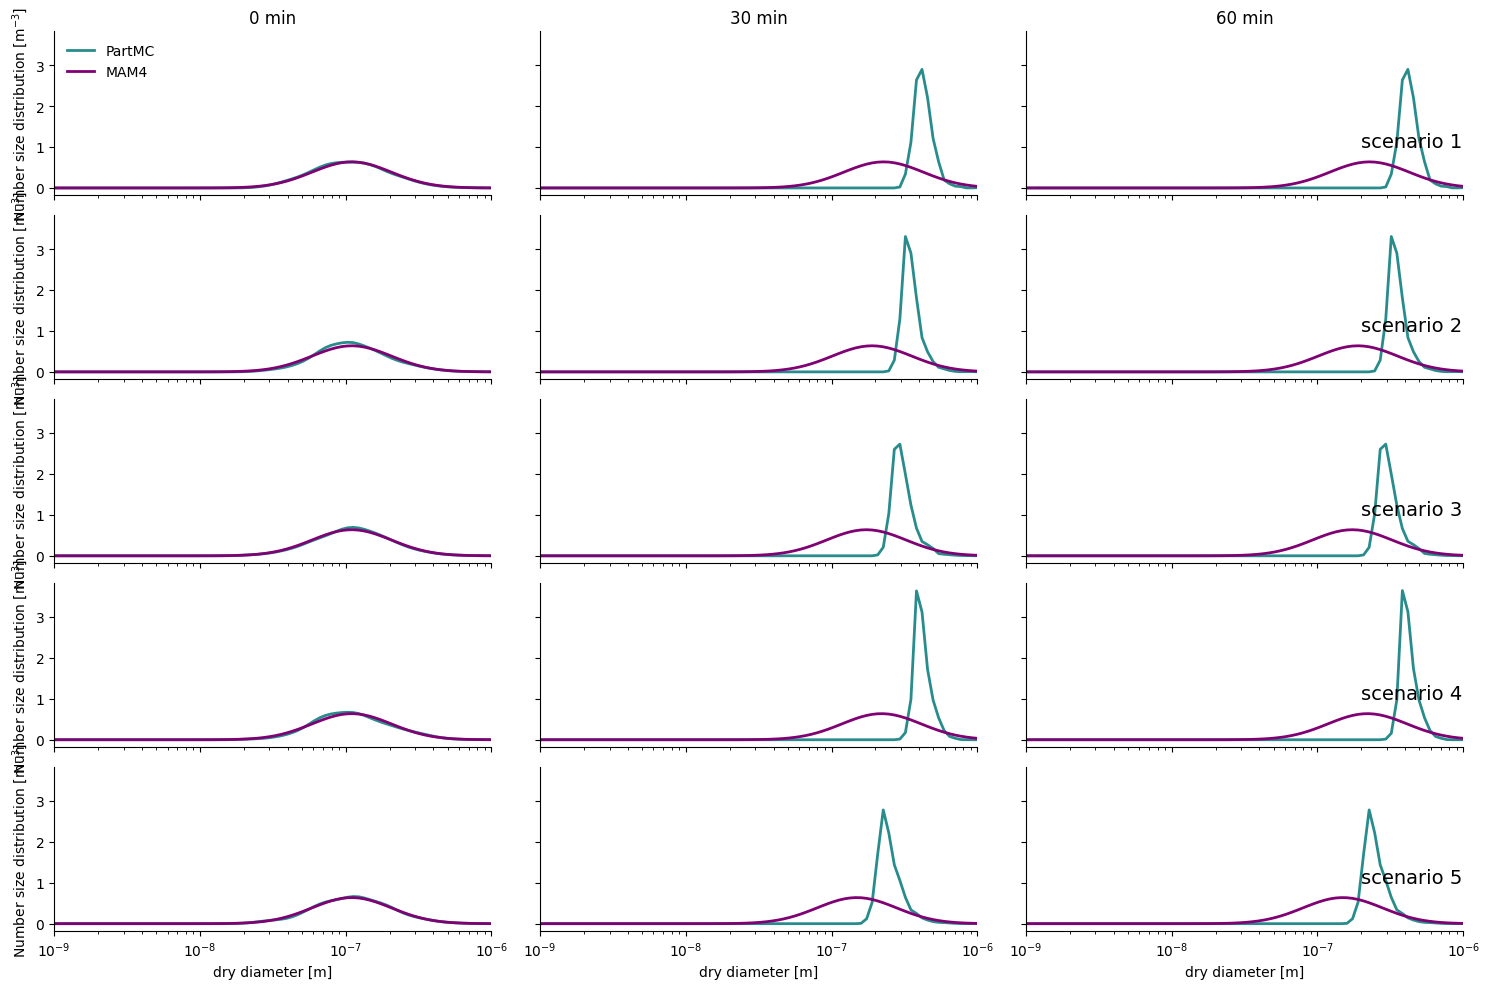

In [ ]:
import matplotlib.pyplot as plt

from pyparticle.viz.style import StyleManager, Theme
from pyparticle.viz.builder import build_plotter
import matplotlib.pyplot as plt
import numpy as np

timesteps = [1, 31, 61]
scenario_names = [str(ii).zfill(1) for ii in range(1, n+1)]
scenarios = scenario_names

# fixme: wrap this in viz module?
fig,ax = plt.subplots(len(scenarios), len(timesteps), figsize=(15,10), squeeze=False, sharex=True, sharey=True)
for i, scenario_name in enumerate(scenarios):
    for j, timestep_to_plot in enumerate(timesteps):
        partmc_output = ambrs.partmc.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=ensemble.member(int(scenario_name) - 1),
            timestep=timestep_to_plot,
            repeat_num=1,
            species_modifications={},
            ensemble_output_dir=partmc_dir,
        )
        mam4_output = ambrs.mam4.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=ensemble.member(int(scenario_name) - 1),
            timestep=timestep_to_plot,
            repeat_num=1,
            species_modifications={},
            ensemble_output_dir=mam4_dir,
        )

        # -----------------------------------------------------------
        # Standardized outputs are used for downstream analysis and visualization
        # -----------------------------------------------------------

        mgr = StyleManager(Theme(), deterministic=False)

        # Lines
        series = [
            {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
            {"key": "mam4", "population": mam4_output.particle_population, "label": "MAM4"},
        ]

        print('Ntot, partmc:', partmc_output.particle_population.get_Ntot())
        print('Ntot, mam4:', mam4_output.particle_population.get_Ntot())

        # print('tot dry mass, partmc:', partmc_output.particle_population.get_tot_dry_mass())
        # print('tot dry mass, mam4:', mam4_output.particle_population.get_tot_dry_mass())

        # print('tot mass, partmc:', partmc_output.particle_population.get_tot_mass())
        # print('tot mass, mam4:', mam4_output.particle_population.get_tot_mass())

        print('total mass, partmc:', np.sum(np.sum(partmc_output.particle_population.spec_masses,axis=1)*partmc_output.particle_population.num_concs))
        print('total mass, mam4:', np.sum(np.sum(mam4_output.particle_population.spec_masses,axis=1)*mam4_output.particle_population.num_concs))

        print('gases, partmc:', partmc_output.gas_mixture)
        print('gases, mam4:', mam4_output.gas_mixture)
        
        # Build line styles after series is known
        line_styles = mgr.plan("line", [s["key"] for s in series])
        line_styles["partmc"]["color"] = "#298c8c"
        line_styles["mam4"]["color"] = "#800074"
        
        N_bins = 50 #len(s['population'].ids)
        D_min = 1e-9#s['population'].get_particle(s['population'].ids[0]).get_Ddry()
        D_max = 1e-6 #s['population'].get_particle(s['population'].ids[N_bins-1]).get_Ddry()
    
        for s in series:
            cfg = {
                "varname": "dNdlnD",
                "var_cfg": {'normalize':False,"method":"kde", "D":np.logspace(np.log10(D_min),np.log10(D_max),N_bins)}, #{"D": np.logspace(-8.5, -6.5, 40),'normalize': True},
                "style": line_styles[s["key"]],
            }
            plotter = build_plotter("state_line", cfg)
            plotter.plot(s["population"], ax[i,j], label=s["label"])
        ax[i,j].set_xscale('log'); 
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        if i == 0:
            ax[i,j].set_title(f'{timestep_to_plot-1} min')
        if i == 0 and j == 0:
            ax[i,j].legend(frameon=False, loc='upper left')
        if j == len(timesteps) - 1:
            ax[i,j].text(2e-7, 1., 'scenario ' + scenario_name, fontsize=14)
        if j > 0:
            ax[i,j].set_ylabel('')
        if i < len(scenarios) - 1:
            ax[i,j].set_xlabel('')
        fig.tight_layout()
fig.savefig("partmc_mam4_dNdlnD.png", dpi=300)

In [ ]:
# -----------------------------------------------------------
# Helper: rows=scenarios, cols = [dN/dlnD, frac_CCN, b_scat(λ, RH=0%)]
# - PartMC: solid
# - MAM4: dashed + thicker
# - Color by scenario (row-wise consistent)
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

# fixme part2pop.viz
from pyparticle.viz.style import StyleManager, Theme
from pyparticle.viz.builder import build_plotter

# -----------------------------------------------------------
# Helpers: retrieve/cache states and plot grids for dNdlnD & frac_ccn
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
from functools import lru_cache

from pyparticle.viz.style import StyleManager, Theme
from pyparticle.viz.builder import build_plotter

# -- small factory: makes a cached retriever bound to your ensemble + output dirs
def make_state_retriever(ensemble, partmc_dir, mam4_dir, *, repeat_num=1):
    cache = {}

    def retrieve(scenario_name: str, timestep: int, species_modifications=None):
        key = (scenario_name, int(timestep))
        if key in cache:
            return cache[key]

        idx = int(scenario_name) - 1
        scen = ensemble.member(idx)

        partmc_output = ambrs.partmc.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=scen,
            timestep=timestep,
            repeat_num=repeat_num,
            species_modifications=species_modifications or {},
            ensemble_output_dir=partmc_dir,
        )
        mam4_output = ambrs.mam4.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=scen,
            timestep=timestep,
            repeat_num=repeat_num,
            species_modifications=species_modifications or {},
            ensemble_output_dir=mam4_dir,
        )
        cache[key] = (partmc_output, mam4_output)
        return cache[key]

    return retrieve


def _plan_styles(series_keys, *, partmc_color="#298c8c", mam4_color="#800074"):
    mgr = StyleManager(Theme(), deterministic=False)
    styles = mgr.plan("line", list(series_keys))
    if "partmc" in styles:
        styles["partmc"]["color"] = partmc_color
    if "mam4" in styles:
        styles["mam4"]["color"] = mam4_color
    return styles


def _format_panel(ax, *, xscale="log"):
    if xscale:
        ax.set_xscale(xscale)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


def plot_grid_dNdlnD(
    ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    *,
    D_range=(1e-9, 1e-6), N_bins=50, normalize=True, method="",
    figsize=(15, 10), legend_loc="upper left", savepath=None
):
    """
    Plot dN/dlnD for (scenarios × timesteps) comparing PartMC vs MAM4.

    Parameters
    ----------
    D_range : (float, float)
        Min/max dry diameter [m] for the plotting grid.
    N_bins : int
        Number of points in the diameter grid (log-spaced).
    normalize : bool
        Normalize spectra (passed to plotter var_cfg).
    method : str
        Optional method flag for your plotter (kept as in your example).
    """
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    fig, ax = plt.subplots(len(scenarios), len(timesteps),
                           figsize=figsize, squeeze=False, sharex=True, sharey=True)

    # pre-build styles once
    series_keys = ("partmc", "mam4")
    line_styles = _plan_styles(series_keys)

    # diameter grid (log-spaced)
    D_min, D_max = D_range
    D_grid = np.logspace(np.log10(D_min), np.log10(D_max), N_bins)

    for i, scenario_name in enumerate(scenarios):
        for j, tstep in enumerate(timesteps):
            partmc_output, mam4_output = retr(scenario_name, tstep)

            series = [
                {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
                {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
            ]
            for s in series:
                cfg = {
                    "varname": "dNdlnD",
                    "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
                    "style": line_styles[s["key"]],
                }
                plotter = build_plotter("state_line", cfg)
                plotter.plot(s["population"], ax[i, j], label=s["label"])

            _format_panel(ax[i, j], xscale="log")
            
            # # titles/labels
            # if i == 0:
            #     ax[i, j].set_title(f"{tstep-1} min")
            if i == 0 and j == 0:
                ax[i, j].legend(frameon=False, loc=legend_loc)
            if j == len(timesteps) - 1:
                # annotate scenario name just outside the right edge, axis coords
                ax[i, j].text(1.02, 0.5, f"scenario {scenario_name}",
                              transform=ax[i, j].transAxes, va="center", fontsize=12)
            if j > 0:
                ax[i, j].set_ylabel("")
            if i < len(scenarios) - 1:
                ax[i, j].set_xlabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, ax


def plot_grid_frac_ccn(
    ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    *,
    s_grid=np.logspace(-2, 1.0, 50),
    figsize=(15, 10), legend_loc="upper left", savepath=None
):
    """
    Plot CCN activated fraction vs supersaturation for (scenarios × timesteps)
    comparing PartMC vs MAM4.

    Parameters
    ----------
    s_grid : array-like
        Supersaturation grid (fractional or percent as expected by your plotter;
        keep as in your current viz API; here it's log-spaced 0.01..10).
    """
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    fig, ax = plt.subplots(len(scenarios), len(timesteps),
                           figsize=figsize, squeeze=False, sharex=True, sharey=True)

    series_keys = ("partmc", "mam4")
    line_styles = _plan_styles(series_keys)

    for i, scenario_name in enumerate(scenarios):
        for j, tstep in enumerate(timesteps):
            partmc_output, mam4_output = retr(scenario_name, tstep)

            series = [
                {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
                {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
            ]
            for s in series:
                cfg = {
                    "varname": "frac_ccn",
                    "var_cfg": {"s_grid": np.asarray(s_grid)},
                    "style": line_styles[s["key"]],
                }
                plotter = build_plotter("state_line", cfg)
                plotter.plot(s["population"], ax[i, j], label=s["label"])

            _format_panel(ax[i, j], xscale="log")

            if i == 0:
                ax[i, j].set_title(f"{tstep-1} min")
            if i == 0 and j == 0:
                ax[i, j].legend(frameon=False, loc=legend_loc)
            if j == len(timesteps) - 1:
                ax[i, j].text(1.02, 0.5, f"scenario {scenario_name}",
                              transform=ax[i, j].transAxes, va="center", fontsize=12)
            if j > 0:
                ax[i, j].set_ylabel("")
            if i < len(scenarios) - 1:
                ax[i, j].set_xlabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, ax



def _scenario_colors(n_rows, palette=None):
    """Generate n_rows distinct colors (row-wise)."""
    if palette is None:
        # tab10 cycles nicely up to 10, then repeats
        cmap = plt.get_cmap("tab10")
        return [cmap(i % 10) for i in range(n_rows)]
    return palette[:n_rows]

def _base_styles():
    mgr = StyleManager(Theme(), deterministic=False)
    return mgr.plan("line", ["partmc", "mam4"])

def plot_scenarios_threecols(
    ensemble, scenarios, timestep, partmc_dir, mam4_dir,
    *,
    # left panel: dN/dlnD
    D_range=(1e-9, 1e-6), N_bins=50, normalize=False, method="kde",
    # middle panel: frac_CCN
    s_grid=np.logspace(-2, 1.0, 50),  # 0.01..10 (fraction)
    # right panel: b_scat vs wavelength @ RH=0
    wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
    RH_for_bscat=np.array([0.0]),
    # figure
    figsize_per_row=2.4, width=14,
    legend_loc="upper left",
    colors=None,
    savepath=None,
):
    """
    Make a grid with rows=scenarios and columns=[dN/dlnD, frac_CCN, b_scat(λ, RH=0%)].

    Parameters
    ----------
    timestep : int
        Model timestep index to retrieve for each scenario.
    D_range : tuple(float, float)
        Dry-diameter range [m] for dN/dlnD grid (log-spaced).
    s_grid : array-like
        Supersaturation grid for frac_CCN (as expected by your viz; here fraction).
    wavelengths_m : array-like
        Wavelength grid [m] for b_scat(λ); RH fixed to RH_for_bscat.
    RH_for_bscat : float
        Relative humidity (fraction) used in scattering calculation (0.0 = 0%).
    """
    n_rows = len(scenarios)
    height = max(2.2, figsize_per_row * n_rows)
    fig, axes = plt.subplots(n_rows, 3, figsize=(width, height), squeeze=False, sharex=False, sharey=False)

    # one-shot retriever to avoid rereading outputs
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    # row colors
    row_colors = _scenario_colors(n_rows, palette=colors)

    # base styles then row-customize
    base = _base_styles()

    # precompute grids
    D_grid = np.logspace(np.log10(D_range[0]), np.log10(D_range[1]), N_bins)
    s_grid = np.asarray(s_grid)
    wl = np.asarray(wavelengths_m)

    for i, scenario_name in enumerate(scenarios):
        partmc_output, mam4_output = retr(scenario_name, timestep)
        series = [
            {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
            {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
        ]

        # styles for this row: same color for both, but different line style/width
        row_style = {
            "partmc": {**base["partmc"], "color": row_colors[i], "linestyle": "-",  "linewidth": 2.0},
            "mam4":   {**base["mam4"],   "color": row_colors[i], "linestyle": "--", "linewidth": 3.0},
        }

        # ----- Col 0: dN/dlnD
        ax0 = axes[i, 0]
        for s in series:
            cfg = {
                "varname": "dNdlnD",
                "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
                "style": row_style[s["key"]],
            }
            build_plotter("state_line", cfg).plot(s["population"], ax0, label=s["label"])
        ax0.set_xscale("log")
        ax0.set_title("dN/dlnD" if i == 0 else "")
        ax0.set_ylabel(f"scenario {scenario_name}", rotation=0, ha="right", va="center") if (0 == 0) else None
        ax0.spines['top'].set_visible(False); ax0.spines['right'].set_visible(False)
        if i == 0:
            ax0.legend(frameon=False, loc=legend_loc)

        # ----- Col 1: frac_CCN vs S
        ax1 = axes[i, 1]
        for s in series:
            cfg = {
                "varname": "frac_ccn",
                "var_cfg": {"s_grid": s_grid},
                "style": row_style[s["key"]],
            }
            build_plotter("state_line", cfg).plot(s["population"], ax1, label=s["label"])
        ax1.set_xscale("log")
        ax1.set_title("CCN fraction" if i == 0 else "")
        ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)

        # ----- Col 2: b_scat(λ) @ RH=0%
        ax2 = axes[i, 2]
        for s in series:
            # ensure wavelength grid is a proper 1-D array
            wl_arr = np.asarray(wl, dtype=float).ravel()
            # normalize RH input to array then scalar if single
            try:
                rh_arr = np.asarray(RH_for_bscat).ravel()
            except Exception:
                rh_arr = np.array([float(RH_for_bscat)])

            # build a flexible var_cfg covering common key names expected by the plotter
            var_cfg = {}
            # prefer 'wvl_grid' (many viz APIs use this) but include fallback keys below
            
            var_cfg["wvl_grid"] = wl_arr
            var_cfg['rh_grid'] = rh_arr
            # if rh_arr.size > 1:
            #     var_cfg["rh_grid"] = rh_arr
            # else:
            #     var_cfg["RH"] = float(rh_arr[0])
            
            cfg = {"varname": "b_scat", "var_cfg": var_cfg, "style": row_style[s["key"]]}
            print(var_cfg)
            print(cfg)
            try:
                build_plotter("state_line", cfg).plot(s["population"], ax2, label=s["label"])
            except ValueError:
                # fallback: try common alternative key names used in older/newer APIs
                fb_var_cfg = {"wavelengths_m": wl_arr, "RH": float(rh_arr[0])}
                build_plotter("state_line", {"varname": "b_scat", "var_cfg": fb_var_cfg, "style": row_style[s["key"]]}).plot(s["population"], ax2, label=s["label"])
        # wavelength axis: keep linear unless you prefer log-λ
        ax2.set_title(r"$b_{\mathrm{scat}}(\lambda)$ @ RH=0%" if i == 0 else "")
        ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

        # tidy row labels
        # place scenario label just outside the left of the first column
        ax0.text(-0.08, 0.5, f"{scenario_name}", transform=ax0.transAxes,
                 rotation=90, va="center", ha="right", fontsize=11)

        # remove repeated x/y labels inside the grid
        if i < n_rows - 1:
            for c in range(3):
                axes[i, c].set_xlabel("")
        if i > 0:
            for c in range(3):
                axes[i, c].set_ylabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, axes


def plot_scenarios_time_evolution(
    ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    *,
    # left panel: dN/dlnD
    D_range=(1e-9, 1e-6), N_bins=50, normalize=False, method="kde",
    # middle panel: frac_CCN
    # s_grid=np.logspace(-2, 1.0, 50),  # 0.01..10 (fraction)
    # # right panel: b_scat vs wavelength @ RH=0
    # wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
    # RH_for_bscat=np.array([0.0]),
    # # figure
    figsize_per_row=2.4, width=14,
    legend_loc="upper left",
    colors=None,
    savepath=None,
):
    """
    Make a grid with rows=scenarios and columns=[dN/dlnD, frac_CCN, b_scat(λ, RH=0%)].

    Parameters
    ----------
    timestep : int
        Model timestep index to retrieve for each scenario.
    D_range : tuple(float, float)
        Dry-diameter range [m] for dN/dlnD grid (log-spaced).
    s_grid : array-like
        Supersaturation grid for frac_CCN (as expected by your viz; here fraction).
    wavelengths_m : array-like
        Wavelength grid [m] for b_scat(λ); RH fixed to RH_for_bscat.
    RH_for_bscat : float
        Relative humidity (fraction) used in scattering calculation (0.0 = 0%).
    """
    n_rows = len(scenarios)
    height = max(2.2, figsize_per_row * n_rows)
    fig, axes = plt.subplots(n_rows, 3, figsize=(width, height), squeeze=False, sharex=False, sharey=False)

    # one-shot retriever to avoid rereading outputs
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    # row colors
    row_colors = _scenario_colors(n_rows, palette=colors)

    # base styles then row-customize
    base = _base_styles()

    # precompute grids
    D_grid = np.logspace(np.log10(D_range[0]), np.log10(D_range[1]), N_bins)
    # s_grid = np.asarray(s_grid)
    # wl = np.asarray(wavelengths_m)

    for i, scenario_name in enumerate(scenarios):
        
        # styles for this row: same color for both, but different line style/width
        row_style = {
            "partmc": {**base["partmc"], "color": row_colors[i], "linestyle": "-",  "linewidth": 2.0},
            "mam4":   {**base["mam4"],   "color": row_colors[i], "linestyle": "--", "linewidth": 3.0},
        }

        # ----- Col 0: dN/dlnD
        for tt, timestep in enumerate(timesteps):
            partmc_output, mam4_output = retr(scenario_name, timestep)
            series = [
                {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
                {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
            ]

            ax0 = axes[i, tt]
            for s in series:
                cfg = {
                    "varname": "dNdlnD",
                    "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
                    "style": row_style[s["key"]],
                }
                build_plotter("state_line", cfg).plot(s["population"], ax0, label=s["label"])
            ax0.set_xscale("log")
            ax0.set_title("dN/dlnD" if i == 0 else "")
            ax0.set_ylabel(f"scenario {scenario_name}", rotation=0, ha="right", va="center") if (0 == 0) else None
            ax0.spines['top'].set_visible(False); ax0.spines['right'].set_visible(False)
            if i == 0:
                ax0.legend(frameon=False, loc=legend_loc)


In [ ]:
# -----------------------------------------------------------
# Helper: rows=scenarios, cols = [dN/dlnD, frac_CCN, b_scat(λ, RH=0%)]
# - PartMC: solid
# - MAM4: dashed + thicker
# - Color by scenario (row-wise consistent)
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

from pyparticle.viz.style import StyleManager, Theme
from pyparticle.viz.builder import build_plotter

# -----------------------------------------------------------
# Helpers: retrieve/cache states and plot grids for dNdlnD & frac_ccn
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
from functools import lru_cache

from pyparticle.viz.style import StyleManager, Theme
from pyparticle.viz.builder import build_plotter

# -- small factory: makes a cached retriever bound to your ensemble + output dirs
def make_state_retriever(ensemble, partmc_dir, mam4_dir, *, repeat_num=1):
    cache = {}

    def retrieve(scenario_name: str, timestep: int, species_modifications=None):
        key = (scenario_name, int(timestep))
        if key in cache:
            return cache[key]

        idx = int(scenario_name) - 1
        scen = ensemble.member(idx)

        partmc_output = ambrs.partmc.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=scen,
            timestep=timestep,
            repeat_num=repeat_num,
            species_modifications=species_modifications or {},
            ensemble_output_dir=partmc_dir,
        )
        mam4_output = ambrs.mam4.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=scen,
            timestep=timestep,
            repeat_num=repeat_num,
            species_modifications=species_modifications or {},
            ensemble_output_dir=mam4_dir,
        )
        cache[key] = (partmc_output, mam4_output)
        return cache[key]

    return retrieve


def _plan_styles(series_keys, *, partmc_color="#298c8c", mam4_color="#800074"):
    mgr = StyleManager(Theme(), deterministic=False)
    styles = mgr.plan("line", list(series_keys))
    if "partmc" in styles:
        styles["partmc"]["color"] = partmc_color
    if "mam4" in styles:
        styles["mam4"]["color"] = mam4_color
    return styles


def _format_panel(ax, *, xscale="log"):
    if xscale:
        ax.set_xscale(xscale)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


def plot_grid_dNdlnD(
    ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    *,
    D_range=(1e-9, 1e-6), N_bins=50, normalize=True, method="",
    figsize=(15, 10), legend_loc="upper left", savepath=None
):
    """
    Plot dN/dlnD for (scenarios × timesteps) comparing PartMC vs MAM4.

    Parameters
    ----------
    D_range : (float, float)
        Min/max dry diameter [m] for the plotting grid.
    N_bins : int
        Number of points in the diameter grid (log-spaced).
    normalize : bool
        Normalize spectra (passed to plotter var_cfg).
    method : str
        Optional method flag for your plotter (kept as in your example).
    """
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    fig, ax = plt.subplots(len(scenarios), len(timesteps),
                           figsize=figsize, squeeze=False, sharex=True, sharey=True)

    # pre-build styles once
    series_keys = ("partmc", "mam4")
    line_styles = _plan_styles(series_keys)

    # diameter grid (log-spaced)
    D_min, D_max = D_range
    D_grid = np.logspace(np.log10(D_min), np.log10(D_max), N_bins)

    for i, scenario_name in enumerate(scenarios):
        for j, tstep in enumerate(timesteps):
            partmc_output, mam4_output = retr(scenario_name, tstep)

            series = [
                {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
                {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
            ]
            for s in series:
                cfg = {
                    "varname": "dNdlnD",
                    "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
                    "style": line_styles[s["key"]],
                }
                plotter = build_plotter("state_line", cfg)
                plotter.plot(s["population"], ax[i, j], label=s["label"])

            _format_panel(ax[i, j], xscale="log")
            
            # # titles/labels
            # if i == 0:
            #     ax[i, j].set_title(f"{tstep-1} min")
            if i == 0 and j == 0:
                ax[i, j].legend(frameon=False, loc=legend_loc)
            if j == len(timesteps) - 1:
                # annotate scenario name just outside the right edge, axis coords
                ax[i, j].text(1.02, 0.5, f"scenario {scenario_name}",
                              transform=ax[i, j].transAxes, va="center", fontsize=12)
            if j > 0:
                ax[i, j].set_ylabel("")
            if i < len(scenarios) - 1:
                ax[i, j].set_xlabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, ax


def plot_grid_frac_ccn(
    ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    *,
    s_grid=np.logspace(-2, 1.0, 50),
    figsize=(15, 10), legend_loc="upper left", savepath=None
):
    """
    Plot CCN activated fraction vs supersaturation for (scenarios × timesteps)
    comparing PartMC vs MAM4.

    Parameters
    ----------
    s_grid : array-like
        Supersaturation grid (fractional or percent as expected by your plotter;
        keep as in your current viz API; here it's log-spaced 0.01..10).
    """
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    fig, ax = plt.subplots(len(scenarios), len(timesteps),
                           figsize=figsize, squeeze=False, sharex=True, sharey=True)

    series_keys = ("partmc", "mam4")
    line_styles = _plan_styles(series_keys)

    for i, scenario_name in enumerate(scenarios):
        for j, tstep in enumerate(timesteps):
            partmc_output, mam4_output = retr(scenario_name, tstep)

            series = [
                {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
                {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
            ]
            for s in series:
                cfg = {
                    "varname": "frac_ccn",
                    "var_cfg": {"s_grid": np.asarray(s_grid)},
                    "style": line_styles[s["key"]],
                }
                plotter = build_plotter("state_line", cfg)
                plotter.plot(s["population"], ax[i, j], label=s["label"])

            _format_panel(ax[i, j], xscale="log")

            if i == 0:
                ax[i, j].set_title(f"{tstep-1} min")
            if i == 0 and j == 0:
                ax[i, j].legend(frameon=False, loc=legend_loc)
            if j == len(timesteps) - 1:
                ax[i, j].text(1.02, 0.5, f"scenario {scenario_name}",
                              transform=ax[i, j].transAxes, va="center", fontsize=12)
            if j > 0:
                ax[i, j].set_ylabel("")
            if i < len(scenarios) - 1:
                ax[i, j].set_xlabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, ax



def _scenario_colors(n_rows, palette=None):
    """Generate n_rows distinct colors (row-wise)."""
    if palette is None:
        # tab10 cycles nicely up to 10, then repeats
        cmap = plt.get_cmap("tab10")
        return [cmap(i % 10) for i in range(n_rows)]
    return palette[:n_rows]

def _base_styles():
    mgr = StyleManager(Theme(), deterministic=False)
    return mgr.plan("line", ["partmc", "mam4"])

def plot_scenarios_threecols(
    ensemble, scenarios, timestep, partmc_dir, mam4_dir,
    *,
    # left panel: dN/dlnD
    D_range=(1e-9, 1e-6), N_bins=50, normalize=False, method="kde",
    # middle panel: frac_CCN
    s_grid=np.logspace(-2, 1.0, 50),  # 0.01..10 (fraction)
    # right panel: b_scat vs wavelength @ RH=0
    wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
    RH_for_bscat=np.array([0.0]),
    # figure
    figsize_per_row=2.4, width=14,
    legend_loc="upper left",
    colors=None,
    savepath=None,
):
    """
    Make a grid with rows=scenarios and columns=[dN/dlnD, frac_CCN, b_scat(λ, RH=0%)].

    Parameters
    ----------
    timestep : int
        Model timestep index to retrieve for each scenario.
    D_range : tuple(float, float)
        Dry-diameter range [m] for dN/dlnD grid (log-spaced).
    s_grid : array-like
        Supersaturation grid for frac_CCN (as expected by your viz; here fraction).
    wavelengths_m : array-like
        Wavelength grid [m] for b_scat(λ); RH fixed to RH_for_bscat.
    RH_for_bscat : float
        Relative humidity (fraction) used in scattering calculation (0.0 = 0%).
    """
    n_rows = len(scenarios)
    height = max(2.2, figsize_per_row * n_rows)
    fig, axes = plt.subplots(n_rows, 3, figsize=(width, height), squeeze=False, sharex=False, sharey=False)

    # one-shot retriever to avoid rereading outputs
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    # row colors
    row_colors = _scenario_colors(n_rows, palette=colors)

    # base styles then row-customize
    base = _base_styles()

    # precompute grids
    D_grid = np.logspace(np.log10(D_range[0]), np.log10(D_range[1]), N_bins)
    s_grid = np.asarray(s_grid)
    wl = np.asarray(wavelengths_m)

    for i, scenario_name in enumerate(scenarios):
        partmc_output, mam4_output = retr(scenario_name, timestep)
        series = [
            {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
            {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
        ]

        # styles for this row: same color for both, but different line style/width
        row_style = {
            "partmc": {**base["partmc"], "color": row_colors[i], "linestyle": "-",  "linewidth": 2.0},
            "mam4":   {**base["mam4"],   "color": row_colors[i], "linestyle": "--", "linewidth": 3.0},
        }

        # ----- Col 0: dN/dlnD
        ax0 = axes[i, 0]
        for s in series:
            cfg = {
                "varname": "dNdlnD",
                "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
                "style": row_style[s["key"]],
            }
            build_plotter("state_line", cfg).plot(s["population"], ax0, label=s["label"])
        ax0.set_xscale("log")
        ax0.set_title("dN/dlnD" if i == 0 else "")
        ax0.set_ylabel(f"scenario {scenario_name}", rotation=0, ha="right", va="center") if (0 == 0) else None
        ax0.spines['top'].set_visible(False); ax0.spines['right'].set_visible(False)
        if i == 0:
            ax0.legend(frameon=False, loc=legend_loc)

        # ----- Col 1: frac_CCN vs S
        ax1 = axes[i, 1]
        for s in series:
            cfg = {
                "varname": "frac_ccn",
                "var_cfg": {"s_grid": s_grid},
                "style": row_style[s["key"]],
            }
            build_plotter("state_line", cfg).plot(s["population"], ax1, label=s["label"])
        ax1.set_xscale("log")
        ax1.set_title("CCN fraction" if i == 0 else "")
        ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)

        # ----- Col 2: b_scat(λ) @ RH=0%
        ax2 = axes[i, 2]
        for s in series:
            # ensure wavelength grid is a proper 1-D array
            wl_arr = np.asarray(wl, dtype=float).ravel()
            # normalize RH input to array then scalar if single
            try:
                rh_arr = np.asarray(RH_for_bscat).ravel()
            except Exception:
                rh_arr = np.array([float(RH_for_bscat)])

            # build a flexible var_cfg covering common key names expected by the plotter
            var_cfg = {}
            # prefer 'wvl_grid' (many viz APIs use this) but include fallback keys below
            
            var_cfg["wvl_grid"] = wl_arr
            var_cfg['rh_grid'] = rh_arr
            # if rh_arr.size > 1:
            #     var_cfg["rh_grid"] = rh_arr
            # else:
            #     var_cfg["RH"] = float(rh_arr[0])
            
            cfg = {"varname": "b_scat", "var_cfg": var_cfg, "style": row_style[s["key"]]}
            print(var_cfg)
            print(cfg)
            try:
                build_plotter("state_line", cfg).plot(s["population"], ax2, label=s["label"])
            except ValueError:
                # fallback: try common alternative key names used in older/newer APIs
                fb_var_cfg = {"wavelengths_m": wl_arr, "RH": float(rh_arr[0])}
                build_plotter("state_line", {"varname": "b_scat", "var_cfg": fb_var_cfg, "style": row_style[s["key"]]}).plot(s["population"], ax2, label=s["label"])
        # wavelength axis: keep linear unless you prefer log-λ
        ax2.set_title(r"$b_{\mathrm{scat}}(\lambda)$ @ RH=0%" if i == 0 else "")
        ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

        # tidy row labels
        # place scenario label just outside the left of the first column
        ax0.text(-0.08, 0.5, f"{scenario_name}", transform=ax0.transAxes,
                 rotation=90, va="center", ha="right", fontsize=11)

        # remove repeated x/y labels inside the grid
        if i < n_rows - 1:
            for c in range(3):
                axes[i, c].set_xlabel("")
        if i > 0:
            for c in range(3):
                axes[i, c].set_ylabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, axes


def plot_scenarios_time_evolution(
    ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    *,
    # left panel: dN/dlnD
    D_range=(1e-9, 1e-6), N_bins=50, normalize=False, method="kde",
    # middle panel: frac_CCN
    # s_grid=np.logspace(-2, 1.0, 50),  # 0.01..10 (fraction)
    # # right panel: b_scat vs wavelength @ RH=0
    # wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
    # RH_for_bscat=np.array([0.0]),
    # # figure
    figsize_per_row=2.4, width=14,
    legend_loc="upper left",
    colors=None,
    savepath=None,
):
    """
    Make a grid with rows=scenarios and columns=[dN/dlnD, frac_CCN, b_scat(λ, RH=0%)].

    Parameters
    ----------
    timestep : int
        Model timestep index to retrieve for each scenario.
    D_range : tuple(float, float)
        Dry-diameter range [m] for dN/dlnD grid (log-spaced).
    s_grid : array-like
        Supersaturation grid for frac_CCN (as expected by your viz; here fraction).
    wavelengths_m : array-like
        Wavelength grid [m] for b_scat(λ); RH fixed to RH_for_bscat.
    RH_for_bscat : float
        Relative humidity (fraction) used in scattering calculation (0.0 = 0%).
    """
    n_rows = len(scenarios)
    height = max(2.2, figsize_per_row * n_rows)
    fig, axes = plt.subplots(n_rows, 3, figsize=(width, height), squeeze=False, sharex=False, sharey=False)

    # one-shot retriever to avoid rereading outputs
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    # row colors
    row_colors = _scenario_colors(n_rows, palette=colors)

    # base styles then row-customize
    base = _base_styles()

    # precompute grids
    D_grid = np.logspace(np.log10(D_range[0]), np.log10(D_range[1]), N_bins)
    # s_grid = np.asarray(s_grid)
    # wl = np.asarray(wavelengths_m)

    for i, scenario_name in enumerate(scenarios):
        
        # styles for this row: same color for both, but different line style/width
        row_style = {
            "partmc": {**base["partmc"], "color": row_colors[i], "linestyle": "-",  "linewidth": 2.0},
            "mam4":   {**base["mam4"],   "color": row_colors[i], "linestyle": "--", "linewidth": 3.0},
        }

        # ----- Col 0: dN/dlnD
        for tt, timestep in enumerate(timesteps):
            partmc_output, mam4_output = retr(scenario_name, timestep)
            series = [
                {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
                {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
            ]

            ax0 = axes[i, tt]
            for s in series:
                cfg = {
                    "varname": "dNdlnD",
                    "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
                    "style": row_style[s["key"]],
                }
                build_plotter("state_line", cfg).plot(s["population"], ax0, label=s["label"])
            ax0.set_xscale("log")
            ax0.set_title("dN/dlnD" if i == 0 else "")
            ax0.set_ylabel(f"scenario {scenario_name}", rotation=0, ha="right", va="center") if (0 == 0) else None
            ax0.spines['top'].set_visible(False); ax0.spines['right'].set_visible(False)
            if i == 0:
                ax0.legend(frameon=False, loc=legend_loc)

        # tidy row labels
        # place scenario label just outside the left of the first column
        ax[i,0].text(-0.08, 0.5, f"{scenario_name}", transform=ax0.transAxes,
                 rotation=90, va="center", ha="right", fontsize=11)
        
        # remove repeated x/y labels inside the grid
        if i < n_rows - 1:
            for c in range(3):
                axes[i, c].set_xlabel("")
        if i > 0:
            for c in range(3):
                axes[i, c].set_ylabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, axes


/Users/fier887/miniforge3/envs/ambrs5/lib/python3.12/site-packages/pyparticle/analysis/population/factory/frac_ccn.py:37: UserWarning: Both 's_grid' and 's_eval' provided with different lengths (50 vs 100). Using 's_grid'.
  warnings.warn(
/Users/fier887/miniforge3/envs/ambrs5/lib/python3.12/site-packages/pyparticle/aerosol_particle.py:262: UserWarning: Surface tension not implemented; returning default 0.072 N/m
  warnings.warn("Surface tension not implemented; returning default 0.072 N/m", UserWarning)


{'wvl_grid': array([3.50000000e-07, 3.65517241e-07, 3.81034483e-07, 3.96551724e-07,
       4.12068966e-07, 4.27586207e-07, 4.43103448e-07, 4.58620690e-07,
       4.74137931e-07, 4.89655172e-07, 5.05172414e-07, 5.20689655e-07,
       5.36206897e-07, 5.51724138e-07, 5.67241379e-07, 5.82758621e-07,
       5.98275862e-07, 6.13793103e-07, 6.29310345e-07, 6.44827586e-07,
       6.60344828e-07, 6.75862069e-07, 6.91379310e-07, 7.06896552e-07,
       7.22413793e-07, 7.37931034e-07, 7.53448276e-07, 7.68965517e-07,
       7.84482759e-07, 8.00000000e-07]), 'rh_grid': array([0.])}
{'varname': 'b_scat', 'var_cfg': {'wvl_grid': array([3.50000000e-07, 3.65517241e-07, 3.81034483e-07, 3.96551724e-07,
       4.12068966e-07, 4.27586207e-07, 4.43103448e-07, 4.58620690e-07,
       4.74137931e-07, 4.89655172e-07, 5.05172414e-07, 5.20689655e-07,
       5.36206897e-07, 5.51724138e-07, 5.67241379e-07, 5.82758621e-07,
       5.98275862e-07, 6.13793103e-07, 6.29310345e-07, 6.44827586e-07,
       6.60344828e-07, 6

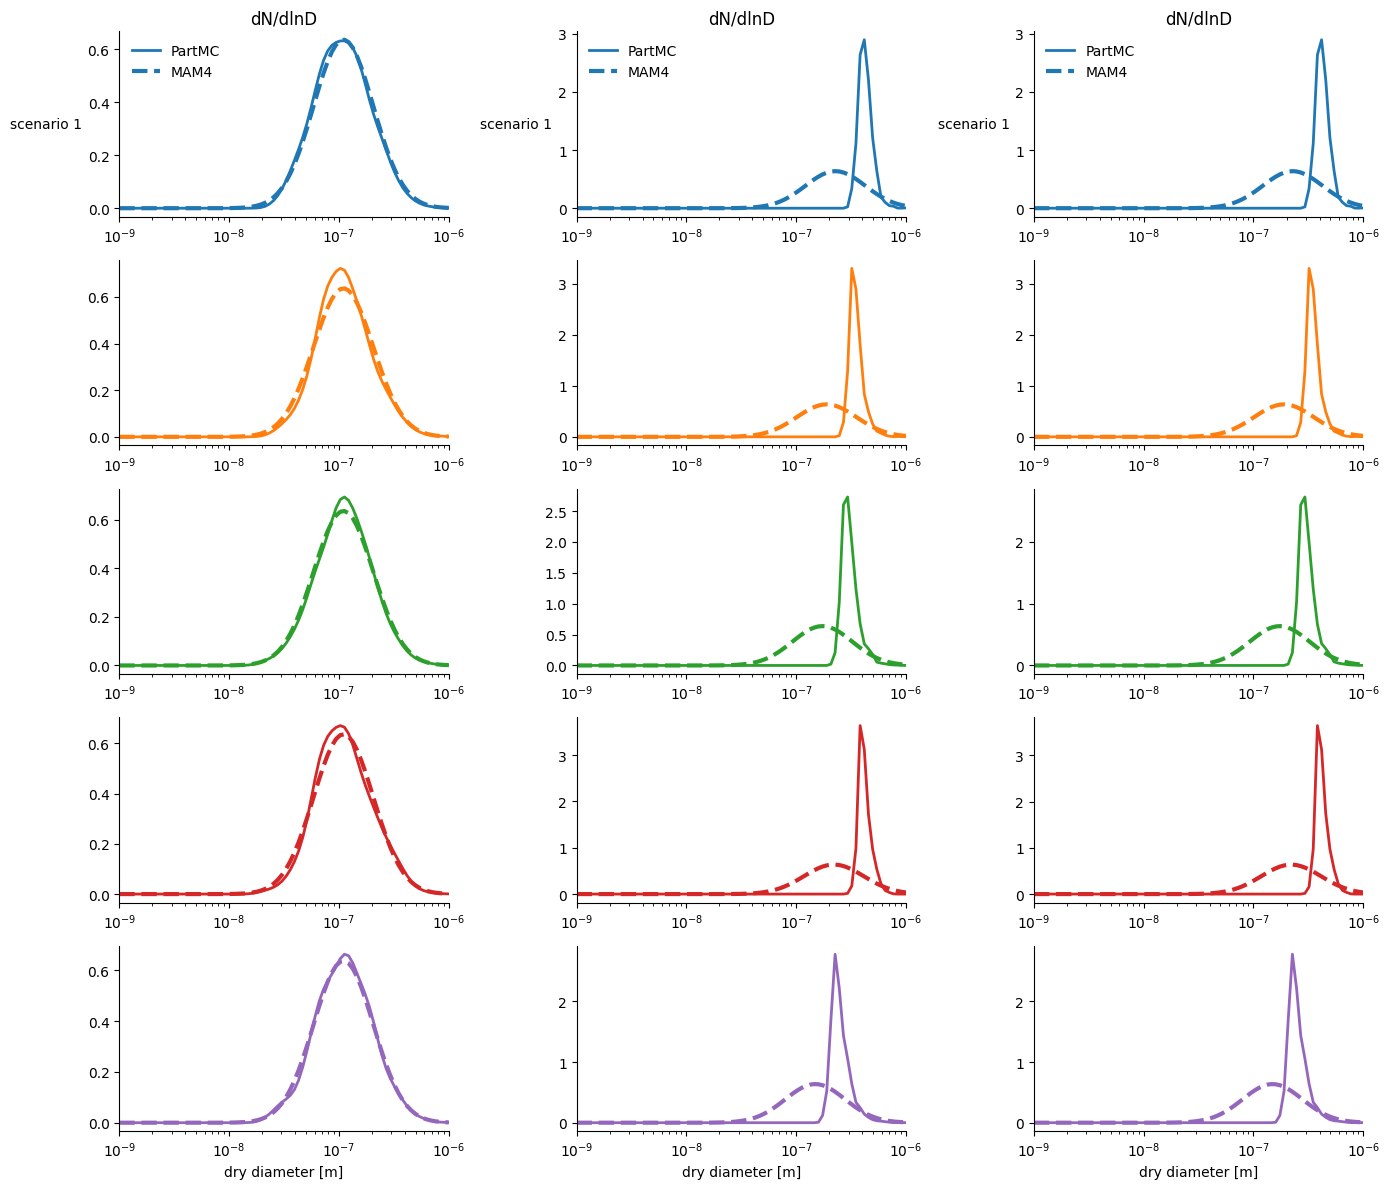

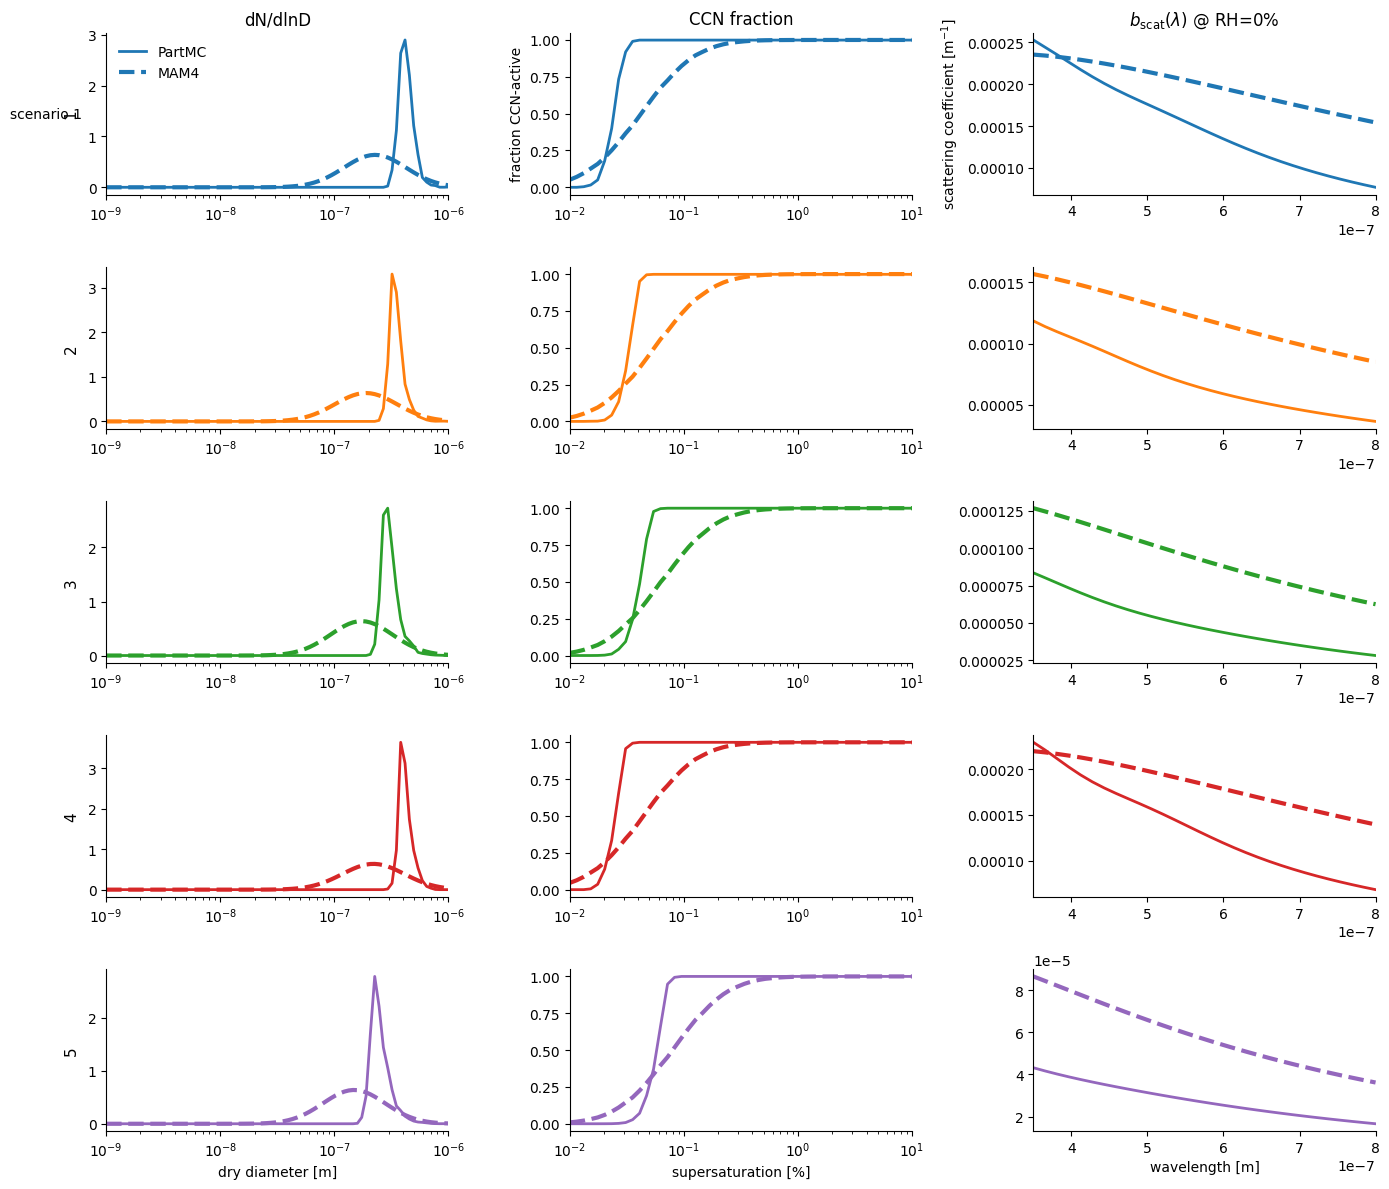

In [ ]:
t_to_plot = 61  # adjust to your file indexing
fig, axes = plot_scenarios_time_evolution(
    ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    D_range=(1e-9, 1e-6), N_bins=50,
    # s_grid=np.logspace(-2, 1.0, 50),
    # wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
    # RH_for_bscat=np.array([0.0]),
    savepath="scenarios_timeseries.png",
    normalize=False
)

# pick a single timestep to compare (e.g., final index)
t_to_plot = 61  # adjust to your file indexing
fig, axes = plot_scenarios_threecols(
    ensemble, scenario_names, t_to_plot, partmc_dir, mam4_dir,
    D_range=(1e-9, 1e-6), N_bins=50,
    s_grid=np.logspace(-2, 1.0, 50),
    wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
    RH_for_bscat=np.array([0.0]),
    savepath="scenarios_threecols.png",
    normalize=False
)


In [ ]:
# # pick a single timestep to compare (e.g., final index)
# t_to_plot = 61  # adjust to your file indexing
# fig, axes = plot_scenarios_threecols_plusInitialPSD(
#     ensemble, scenario_names, t_to_plot, partmc_dir, mam4_dir,
#     D_range=(1e-9, 1e-6), N_bins=50,
#     s_grid=np.logspace(-2, 1.0, 50),
#     wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
#     RH_for_bscat=np.array([0.0]),
#     savepath="scenarios_fourcols.png",
#     normalize=False
# )


In [ ]:
# # After runs (or even interactively for a subset):
# timesteps = [1, 31, 61]
# scenarios = scenario_names

# # dN/dlnD grid
# fig1, ax1 = plot_grid_dNdlnD(
#     ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
#     D_range=(1e-9, 1e-6), N_bins=50, normalize=False, method="kde",
#     savepath="partmc_mam4_dNdlnD.png",
# )

# # CCN fraction grid
# fig2, ax2 = plot_grid_frac_ccn(
#     ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
#     s_grid=np.logspace(-2, 1., 50),
#     savepath="partmc_mam4_frac_ccn.png",
# )


In [ ]:
# ===========================================================
# Flexible grid renderer (rows=scenarios × cols=user-defined)
# - Accepts a matplotlib.gridspec.GridSpec
# - Works for dNdlnD, frac_ccn, b_scat, etc. via var_cfg builders
# - PartMC solid / MAM4 dashed+thicker; color by scenario (row)
# ===========================================================
from typing import Callable, Iterable, Sequence, Tuple, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

from pyparticle.viz.style import StyleManager, Theme
from pyparticle.viz.builder import build_plotter

# -----------------------------------------------------------
# Reuseable: cached state retriever (your original pattern)
# -----------------------------------------------------------
def make_state_retriever(ensemble, partmc_dir, mam4_dir, *, repeat_num=1):
    cache = {}

    def retrieve(scenario_name: str, timestep: int, species_modifications=None):
        key = (scenario_name, int(timestep))
        if key in cache:
            return cache[key]

        idx = int(scenario_name) - 1
        scen = ensemble.member(idx)

        # Assumes `ambrs` is available in your environment
        partmc_output = ambrs.partmc.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=scen,
            timestep=timestep,
            repeat_num=repeat_num,
            species_modifications=species_modifications or {},
            ensemble_output_dir=partmc_dir,
        )
        mam4_output = ambrs.mam4.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=scen,
            timestep=timestep,
            repeat_num=repeat_num,
            species_modifications=species_modifications or {},
            ensemble_output_dir=mam4_dir,
        )
        cache[key] = (partmc_output, mam4_output)
        return cache[key]

    return retrieve


# -----------------------------------------------------------
# Styling helpers (row color, solid vs dashed, thicker MAM4)
# -----------------------------------------------------------
def _scenario_colors(n_rows: int, palette=None):
    if palette is not None:
        return palette[:n_rows]
    cmap = plt.get_cmap("tab10")
    return [cmap(i % 10) for i in range(n_rows)]

def _base_styles():
    # Start from your theme so font/rcParams stay consistent
    mgr = StyleManager(Theme(), deterministic=False)
    return mgr.plan("line", ["partmc", "mam4"])

def _row_styles(base_styles: Dict[str, Dict[str, Any]], color) -> Dict[str, Dict[str, Any]]:
    # PartMC: solid; MAM4: dashed + thicker; both share row color
    return {
        "partmc": {**base_styles["partmc"], "color": color, "linestyle": "-",  "linewidth": 2.0},
        "mam4":   {**base_styles["mam4"],   "color": color, "linestyle": "--", "linewidth": 3.0},
    }

def _format_panel(ax, *, xscale=None):
    if xscale:
        ax.set_xscale(xscale)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


# -----------------------------------------------------------
# Column builder pattern
# - You pass a function that, given a column key (e.g., timestep),
#   returns (var_cfg: dict, title: str)
# -----------------------------------------------------------
VarCfgBuilder = Callable[[Any], Tuple[Dict[str, Any], str]]

def make_dNdlnD_cfg_builder(*, D_range=(1e-9, 1e-6), N_bins=50, normalize=True, method=""):
    D_min, D_max = D_range
    D_grid = np.logspace(np.log10(D_min), np.log10(D_max), int(N_bins))

    def builder(col_value) -> Tuple[Dict[str, Any], str]:
        # col_value is commonly the timestep; title can reflect that
        title = f"t={col_value-1} min" if isinstance(col_value, (int, np.integer)) else str(col_value)
        return ({"D": D_grid, "normalize": normalize, "method": method}, title)
    return builder

def make_frac_ccn_cfg_builder(*, s_grid=np.logspace(-2, 1.0, 50)):
    s = np.asarray(s_grid)
    def builder(col_value) -> Tuple[Dict[str, Any], str]:
        title = f"t={col_value-1} min" if isinstance(col_value, (int, np.integer)) else str(col_value)
        return ({"s_grid": s}, title)
    return builder

def make_bscat_cfg_builder(*, wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30), RH=0.0):
    wl = np.asarray(wavelengths_m).ravel()
    RH_scalar = float(np.asarray(RH).ravel()[0])
    def builder(col_value) -> Tuple[Dict[str, Any], str]:
        title = f"t={col_value-1} min" if isinstance(col_value, (int, np.integer)) else str(col_value)
        # Prefer 'wvl_grid' + 'rh_grid' to match your newer API; callers can change if needed
        return ({"wvl_grid": wl, "rh_grid": np.array([RH_scalar])}, title)
    return builder


# -----------------------------------------------------------
# Core engine: render_variable_grid(...)
# - Uses your retriever + build_plotter("state_line", cfg)
# - Fills the provided GridSpec (must be at least rows×cols big)
# -----------------------------------------------------------
DEFAULT_XSCALE = {
    "dNdlnD"  : "log",
    "frac_ccn": "log",
    "b_scat"  : None,
}

def render_variable_grid(
    gs,                               # matplotlib.gridspec.GridSpec
    *,
    ensemble,
    scenarios: Sequence[str],
    columns: Sequence[Any],           # e.g., timesteps [1, 3, 6] or ["t0","t1",...]
    partmc_dir: str,
    mam4_dir: str,
    varname: str,                     # e.g., "dNdlnD", "frac_ccn", "b_scat"
    build_var_cfg: VarCfgBuilder,     # maps column value -> (var_cfg, title)
    legend_loc: str = "upper left",
    row_label_fmt: str = "scenario {name}",
    row_colors: Sequence[Any] | None = None,
    xscale: str | None = None,        # None -> uses DEFAULT_XSCALE[varname] if present
) -> Tuple[plt.Figure, np.ndarray]:
    """
    Render a grid where rows = scenarios and columns = user-defined 'columns'
    (e.g., timesteps). Draws PartMC vs MAM4 overlays per cell.

    Returns
    -------
    fig, axes : (matplotlib.figure.Figure, np.ndarray[(n_rows, n_cols)])
    """
    fig = gs.figure
    n_rows, n_cols = len(scenarios), len(columns)

    # sanity: GridSpec must be big enough
    if getattr(gs, "nrows", None) is not None and getattr(gs, "ncols", None) is not None:
        if gs.nrows < n_rows or gs.ncols < n_cols:
            raise ValueError(f"GridSpec too small: needs at least {n_rows}×{n_cols}, "
                             f"got {gs.nrows}×{gs.ncols}")

    axes = np.empty((n_rows, n_cols), dtype=object)
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)
    base = _base_styles()
    colors = _scenario_colors(n_rows) if row_colors is None else list(row_colors)
    xsc = DEFAULT_XSCALE.get(varname, None) if xscale is None else xscale

    for i, scenario_name in enumerate(scenarios):
        row_style = _row_styles(base, colors[i])

        for j, col_value in enumerate(columns):
            ax = fig.add_subplot(gs[i, j])
            axes[i, j] = ax

            # Pull states once per cell
            partmc_output, mam4_output = retr(scenario_name, col_value)
            series = (
                ("partmc", partmc_output.particle_population, "PartMC"),
                ("mam4",   mam4_output.particle_population,   "MAM4"),
            )

            # Build var_cfg + column title
            var_cfg, col_title = build_var_cfg(col_value)

            # Plot both series
            for key, population, label in series:
                cfg = {"varname": varname, "var_cfg": var_cfg, "style": row_style[key]}
                build_plotter("state_line", cfg).plot(population, ax, label=label)

            # panel cosmetics
            _format_panel(ax, xscale=xsc)

            # column titles (top row only)
            if i == 0 and col_title:
                ax.set_title(col_title)

            # legend (only once)
            if i == 0 and j == 0:
                ax.legend(frameon=False, loc=legend_loc)

            # left-hand row labels (first column)
            if j == 0 and row_label_fmt:
                ax.text(-0.08, 0.5, row_label_fmt.format(name=scenario_name),
                        transform=ax.transAxes, rotation=90, va="center", ha="right", fontsize=11)

            # remove repeated labels inside the grid
            if i < n_rows - 1:
                ax.set_xlabel("")
            if j > 0:
                ax.set_ylabel("")

    fig.canvas.draw_idle()
    return fig, axes


# -----------------------------------------------------------
# Convenience wrappers for common cases
# -----------------------------------------------------------
def render_dNdlnD_vs_time(
    gs, *, ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    D_range=(1e-9, 1e-6), N_bins=50, normalize=True, method="",
    legend_loc="upper left",
):
    return render_variable_grid(
        gs,
        ensemble=ensemble,
        scenarios=scenarios,
        columns=list(timesteps if isinstance(timesteps, Iterable) else [timesteps]),
        partmc_dir=partmc_dir,
        mam4_dir=mam4_dir,
        varname="dNdlnD",
        build_var_cfg=make_dNdlnD_cfg_builder(
            D_range=D_range, N_bins=N_bins, normalize=normalize, method=method
        ),
        legend_loc=legend_loc,
        row_label_fmt="scenario {name}",
    )

def render_frac_ccn_vs_time(
    gs, *, ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    s_grid=np.logspace(-2, 1.0, 50), legend_loc="upper left",
):
    return render_variable_grid(
        gs,
        ensemble=ensemble,
        scenarios=scenarios,
        columns=list(timesteps if isinstance(timesteps, Iterable) else [timesteps]),
        partmc_dir=partmc_dir,
        mam4_dir=mam4_dir,
        varname="frac_ccn",
        build_var_cfg=make_frac_ccn_cfg_builder(s_grid=s_grid),
        legend_loc=legend_loc,
        row_label_fmt="scenario {name}",
    )

def render_bscat_vs_time(
    gs, *, ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30), RH=0.0, legend_loc="upper left",
):
    return render_variable_grid(
        gs,
        ensemble=ensemble,
        scenarios=scenarios,
        columns=list(timesteps if isinstance(timesteps, Iterable) else [timesteps]),
        partmc_dir=partmc_dir,
        mam4_dir=mam4_dir,
        varname="b_scat",
        build_var_cfg=make_bscat_cfg_builder(wavelengths_m=wavelengths_m, RH=RH),
        legend_loc=legend_loc,
        row_label_fmt="scenario {name}",
    )

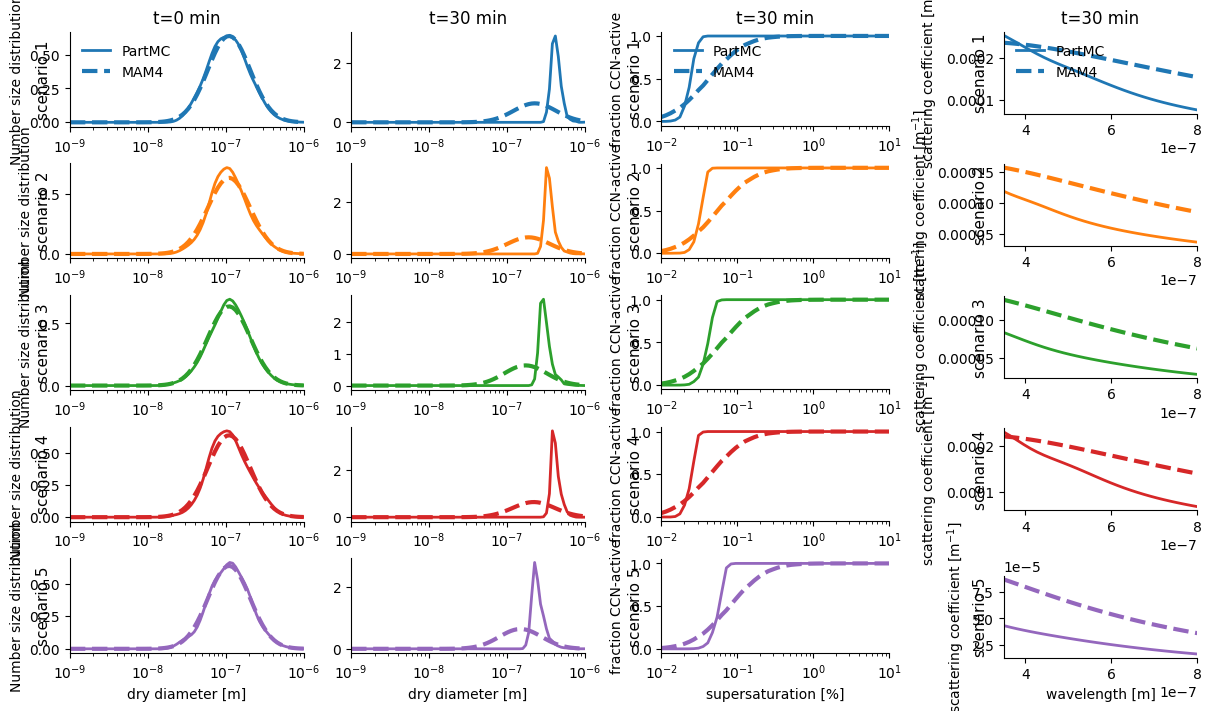

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec as mgs  # <-- for GridSpecFromSubplotSpec

scenarios = ["1","2","3","4","5"]   # rows
timesteps = [1, 31]                 # columns (2 left subcolumns)

fig = plt.figure(constrained_layout=True, figsize=(12, 7))

# Make a 3-column OUTER grid: [DSD block | CCN | SCAT]
# Give the left block width proportional to number of timesteps.
outer = fig.add_gridspec(
    nrows=len(scenarios), ncols=3,
    width_ratios=[len(timesteps), 1, 1],
    hspace=0.1, wspace=0.2
)

# Now make CHILD grids for each block using GridSpecFromSubplotSpec
gs_dsd  = mgs.GridSpecFromSubplotSpec(len(scenarios), len(timesteps), subplot_spec=outer[:, 0])
gs_ccn  = mgs.GridSpecFromSubplotSpec(len(scenarios), 1,              subplot_spec=outer[:, 1])
gs_scat = mgs.GridSpecFromSubplotSpec(len(scenarios), 1,              subplot_spec=outer[:, 2])

# ---- render the left block (dN/dlnD across time)
render_dNdlnD_vs_time(
    gs_dsd,
    # fig=fig,                      # <-- pass fig so the renderer doesn’t need gs.figure
    ensemble=ensemble,
    scenarios=scenarios,
    timesteps=timesteps,          # 2 columns on the left
    partmc_dir=partmc_dir,
    mam4_dir=mam4_dir,
    D_range=(1e-9, 1e-6),
    N_bins=60,
    normalize=True,
    method="kde",
)

render_frac_ccn_vs_time(gs_ccn, #fig=fig, 
                        ensemble=ensemble, scenarios=scenarios,
                        timesteps=[31], partmc_dir=partmc_dir, mam4_dir=mam4_dir)


render_bscat_vs_time(gs_scat, #fig=fig, 
                     ensemble=ensemble, scenarios=scenarios,
                        timesteps=[31], partmc_dir=partmc_dir, mam4_dir=mam4_dir)
plt.show()
